In [363]:
#IMPORTING LIBRARIES

import scipy.special as sp # UNUSED?
import numpy as np # NumPy offers comprehensive mathematical functions, random number generators, linear algebra routines, Fourier transforms, and more
import matplotlib.pyplot as plt # Provides a MATLAB-like way of plotting
import pandas as pd # Data analysis and manipulation tool. Used to read in bathymetry data (M77T file), Directions data (excel file), and organises Vmean into a labelled data structure
# M77T data files are created from raw data collected by marine researchers using InfoBank
from scipy.interpolate import CubicSpline as SP # Used to create a spline about the velocity, shape parameter and proability data
from scipy.optimize import minimize,least_squares,Bounds,basinhopping # Optimizing and route finding
from scipy.special import gamma # Gamma function used for weibull distribution
import matplotlib.cm as cm # UNUSED?
from Boruvka_Mod import Graph # imports class graph from Boruvka_Mod python file
import utm # Used to help convert latitude and longitude in bathymetry data to centred eastings and northings
import scipy.interpolate as spline # Used to smooth the bathymetry data
from matplotlib.colors import ListedColormap # UNUSED?
import math # Provides access to the mathematical functions
from time import perf_counter # Returns the float value of time in seconds. Used to record run time for clustering and optimization algorithms
from minmax_kmeans import minsize_kmeans # imports minsize_kmeans function from minmax_kmeans python file
import pulp #Used in the clustering algorithm to generate MPS and LP files
import scipy.signal as signal 
from scipy.signal import savgol_filter
from scipy.interpolate import make_interp_spline, BSpline
from scipy.spatial import ConvexHull
from GP_functions1 import GP_train, GP_predict


In [364]:
# KEY PARAMETERS USED THROUGHOUT MODEL

a = 300 # minimum distances turbines can be from one another in m.
b = 3000 # distance that turbines have negligible affect on eachother in m. If model changes this value could change

maximumturbinespertree = 10 # number of turbines allowed along a single cable from the substation.
budget = np.float64(200000000) # Budget in £ to build the wind farm, accounting for construction costs.
DistanceToShore = 15000 # m #distance of the wind farm from shore
TooCloseShore = 5000 # m # minimum distance the wind farm must be from shore
xCoordOnshoreSub = 0 # x coordinate of the onshore substation (y coordinate is -(DistanceToShore))

USDtoGBP = 1/1.351  
EURtoGBP = 1/1.19

IACableCostperMeter = 409.2*EURtoGBP
ExportCableCostperMeter = 833.625*EURtoGBP

CostperTurbineUSD = np.float64(3000000) # USD
CostperTurbine = CostperTurbineUSD*USDtoGBP # GBP

OperatingandMaintenanceCostsperAnnum = np.float64(65500) # GBP
LifeTimeTurbineOperatingTime = 20 # years 120000 # hours
MaintenanceCostperTurbine = OperatingandMaintenanceCostsperAnnum*LifeTimeTurbineOperatingTime # in GBP

LandCostperHectare = 17245 # in GBP
LandCostpermSquared = LandCostperHectare/10000 #  in GBP

OffshoreSubstationCostperMW = np.float64(104000*EURtoGBP)
OnshoreSubstationCostperMW = np.float64(87250*EURtoGBP)
# Costs  associated with the purchase and installation of electrical substations as well as the buildings required for housing the staff and additional equipment required for the running of the wind farm.

ElectricityCostperkWh = 0.144 # 14.4 pence - £0.144
DiscountRate = 0.07 # 7%

TurbineRating = 2 #2MW

GravityBase = 409000*EURtoGBP*TurbineRating #409000euro/MW
Monopile = 551000*EURtoGBP*TurbineRating
Jacket = 665000*EURtoGBP*TurbineRating
TensionLeg = 1163000*EURtoGBP*TurbineRating

In [365]:
#READING IN BATHYMETRY DATA
data = pd.read_csv("nsea86.m77t", sep='\t') # Reads in all data from file including depth data, lattitude, longitude etc.
mindepth = min(data['CORR_DEPTH']) # Retrieves minimum depth value from data file 'nsea86.m77t'    
print('Shallowest depth:', mindepth, 'm') #Prints out the result for the smallest depth value

Shallowest depth: 17.2 m


In [366]:
###CALCULATES THE INITIAL NUMBER OF TURBINES THE OPTIMISATION SHOULD START WITH.    
maxnodespertree = maximumturbinespertree # As above
minareaperturbine = (1/2)*(math.sqrt(3))*(a**2) # Area per turbine assuming 350m between each turbine
LandCostperTurbine=minareaperturbine*(LandCostpermSquared) # Cost with minimum area
MinDepthCostPerTurbine = CostperTurbine*(0.0002*(float(mindepth)**2) - 0.0002*(float(mindepth)) + 0.9459)-CostperTurbine # Uses shallowest depth from before
print('Min depth cost per turbine = £',MinDepthCostPerTurbine) # prints result
MinIACableCostPerTurbine = a*IACableCostperMeter
MinExportCableCost = TooCloseShore*ExportCableCostperMeter # minimum export cable cost with respect to the minimum distance the wind farm must be form shore
MinFoundationCostPerTurbine = GravityBase*TurbineRating

MinCostperTurbTot = CostperTurbine+LandCostperTurbine+MaintenanceCostperTurbine+MinDepthCostPerTurbine+MinIACableCostPerTurbine+MinFoundationCostPerTurbine # Total costs (excluding export cable and fixed costs)
nnturb = (budget-MinExportCableCost)/MinCostperTurbTot 
FixedCost = (OffshoreSubstationCostperMW+OnshoreSubstationCostperMW)*nnturb*TurbineRating # *2 due to 2MW turbines being used *0.4 for assuming 40% effciency
nturb = (budget-FixedCost-MinExportCableCost)/(MinCostperTurbTot) # Turbines possible with current budget
nturb = math.floor(nturb) # rounds down as cannot have fraction of a turbine
minarea = minareaperturbine*nturb # Overall minimum area considering the amount of turbines
maxarea = nturb*(1/2)*(math.sqrt(3))*(b**2) # Careful this isn't bigger than the entire size of the scaled nsea86 sea floor.

print('Min area per turbine =', minareaperturbine, 'm^2') # prints results
print('Min area =', minarea, 'm^2')
print('Max number of turbines =', nturb)
print('Max area =', maxarea, 'm^2')

Min depth cost per turbine = £ 3615.099925980903
Min area per turbine = 77942.28634059947 m^2
Min area = 2727980.0219209814 m^2
Max number of turbines = 35
Max area = 272798002.19209814 m^2


In [367]:
#PRE-OPTIMISATION TURBINE POSITIONING

# places substation at (0,0).
# places 1st turbine at vector (a,0) from substation. a=350m from before
# places 2nd turbine at vector (0.5a,0.5aroot3) from prev. 
# places 3rd turbine at vector (-a,0) from prev
# places 4th turbine at vector (-0.5a,-0.5aroot3) from prev, continues in this spiralling fashion

positionlist = np.empty((nturb+1,2)) # Creates an empty list of size (number of turbines + 1 (since 0 position is substation),2)
turbineposition = np.array([[0,0]]) # Creates [0,0] array for introducing [x,y] coordinates for each turbine
positionlist[0,:] = turbineposition # 

oddcounter = 0
evencounter = 0
i = 0
k = 0

while k<nturb+1: # Loops for number of turbines 
    i += 1
    if (i%2)!= 0: # i is odd
        oddcounter+=1
        for j in range(oddcounter):
            k += 1
            if k == nturb+1:
                break
            if (oddcounter%2)!= 0: #oddcounter is odd
                shift = np.array([[a, 0]])
            else:
                shift = np.array([[-a, 0]])
            turbineposition = np.add(turbineposition, shift)
            positionlist[k,:] = turbineposition
        
    else:
        evencounter+=1
        for j in range(evencounter):
            k += 1
            if k == nturb+1:
                break
            if (evencounter%2)!= 0: #evencounter is odd
                shift = np.array([[0.5*a,0.5*a*math.sqrt(3)]])
            else:
                shift = np.array([[-0.5*a,-0.5*a*math.sqrt(3)]]) 
            turbineposition = np.add(turbineposition, shift)
            positionlist[k,:] = turbineposition
                
print(positionlist) # prints positions data        
print(len(positionlist)) # prints length of positions list (should be the number of turbines + 1 for the subsation)

[[   0.            0.        ]
 [ 300.            0.        ]
 [ 450.          259.80762114]
 [ 150.          259.80762114]
 [-150.          259.80762114]
 [-300.            0.        ]
 [-450.         -259.80762114]
 [-150.         -259.80762114]
 [ 150.         -259.80762114]
 [ 450.         -259.80762114]
 [ 600.            0.        ]
 [ 750.          259.80762114]
 [ 900.          519.61524227]
 [ 600.          519.61524227]
 [ 300.          519.61524227]
 [   0.          519.61524227]
 [-300.          519.61524227]
 [-450.          259.80762114]
 [-600.            0.        ]
 [-750.         -259.80762114]
 [-900.         -519.61524227]
 [-600.         -519.61524227]
 [-300.         -519.61524227]
 [   0.         -519.61524227]
 [ 300.         -519.61524227]
 [ 600.         -519.61524227]
 [ 750.         -259.80762114]
 [ 900.            0.        ]
 [1050.          259.80762114]
 [1200.          519.61524227]
 [1350.          779.42286341]
 [1050.          779.42286341]
 [ 750. 

In [368]:
# Shoreline implementation

XShoreLine = np.array([np.linspace(min(positionlist[:,0])-2500,max(positionlist[:,0])+2500,1000)]) #Creates x coordinates of shoreline bewtween min and max turbine locations +/- 1000m # 1000 data points
YShoreLine = np.array([np.linspace(-DistanceToShore,-DistanceToShore,1000)]) #Creates y coordinates of shoreline at -(distance of the wind farm from the shore) # 1000 data points
TXShoreLine = np.transpose(XShoreLine) #transpose of x coordinates
TYShoreLine = np.transpose(YShoreLine) #transpose of y coordinates
TShoreLine = np.concatenate((TXShoreLine,TYShoreLine),axis=1) # Shoreline (x,y)

In [369]:
# Finds distance between substation and shore

def Substation_To_Shore_Connection(positionlist):
    
    OnshoreSubstation = [xCoordOnshoreSub,-DistanceToShore] # Determines fixed position of onshore substation
    ExportDistance = np.sqrt(((positionlist[0,0]-OnshoreSubstation[0])**2)+((positionlist[0,1]-OnshoreSubstation[1])**2)) # min Hypotenuse for distances between substations
    
    return OnshoreSubstation,ExportDistance

OnshoreSubstation,ExportDistance = Substation_To_Shore_Connection(positionlist) #Initially Executes algorithm

print(OnshoreSubstation)
print(np.shape(OnshoreSubstation))
print(ExportDistance)

[0, -15000]
(2,)
15000.0


In [370]:
# Pushes wind farm further out if the smallest distance between the shore and center of wind farm is too small
# Only used for the pre-optimised layout
#In terms of keeping it this way there are bounds on (minimize(targetfunction, initial guess, bounds,.....etc.) the optimization function

CloseTurbY = min(positionlist[:,1]) # y coordinate of closest turbine
CloseTurbYindex = np.argmin(positionlist[:,1]) # index from closest turbine on y axis
CloseTurbX = positionlist[CloseTurbYindex,0] # x coordinate of closest turbine on y axis
DistanceToMinTurb = min(np.sqrt((CloseTurbX-TXShoreLine[:,0])**2+(CloseTurbY-TYShoreLine[:,0])**2)) #min distance from shore to closest turbine 
s = 0

if DistanceToMinTurb < TooCloseShore: # if closest turbine is too close to the shore
    for s in range(0,nturb+1): # loops for number of turbines plus the substation
        positionlist[s,1] = positionlist[s,1] + (TooCloseShore-DistanceToMinTurb)
        # Shifts entire wind farm up by the difference to achieve the minimum distance required
    Substation_To_Shore_Connection(positionlist) #Calls function to redo substation to shore connection with new values

(-16519.615242270665, -619.6152422706632)

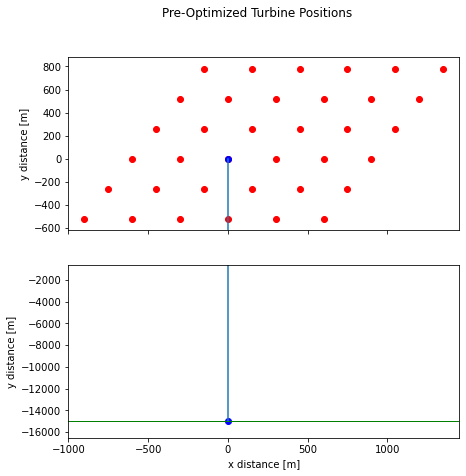

In [371]:
# Display pre-optimized turbine positions before clustering and MST

fig, (ax1,ax2) = plt.subplots(2,sharex=True,figsize=(7,7))
fig.suptitle('Pre-Optimized Turbine Positions')

#Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)    
ax1.scatter(positionlist[:,0],positionlist[:,1],c='red') # Prints turbine positions in red
ax1.scatter(positionlist[0,0],positionlist[0,1],c='blue') # offshore Substation
ax1.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax1.set_ylabel('y distance [m]') # y axis label
ax1.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax1.set_ylim([min(positionlist[:,1])-100, max(positionlist[:,1])+100]) #y limits 

#Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
ax2.scatter(OnshoreSubstation[0],OnshoreSubstation[1],c='blue') #onshore substation
ax2.plot(TXShoreLine,TYShoreLine,c='green',linewidth=1) #Produces line representing the shore line in green
ax2.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax2.set_xlabel('x distance [m]') # x axis label
ax2.set_ylabel('y distance [m]') # y axis label
ax2.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax2.set_ylim([min(positionlist[:,1])-DistanceToShore-1000, min(positionlist[:,1])-100]) #y limits

In [372]:
#Function to determine land cost of wind farm using a convex hull
#Calcualtes area of wind farm, onshore substation, and export cable
#Won't work for just 1 turbine since no boundary to enclose

def LandAreaCost(positionlist,ExportDistance):
    
    radius = 130 #m
    OnshoreSubLand = np.pi*radius**2 #Land area associated with the onshore substation
    ExportLand = ExportDistance*8 # Length*width 
    
    hull = ConvexHull(positionlist) #computes convex hull using the turbine positions
    LandArea = hull.volume + OnshoreSubLand + ExportLand #Calcualtes convex hull area and adds on the onshore substation land area

    LandCost = LandArea*LandCostpermSquared
    
    return LandCost

LandCost = LandAreaCost(positionlist,ExportDistance)

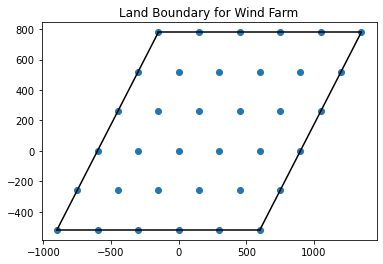

In [373]:
#Visual aid for convex hull plotting

hull = ConvexHull(positionlist)
plt.plot(positionlist[:,0], positionlist[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(positionlist[simplex, 0], positionlist[simplex, 1], 'k-')


plt.title('Land Boundary for Wind Farm')
plt.show()

 C:\Users\adamb\anaconda3\lib\site-packages\pulp\pulp.py:1352: UserWarning:Spaces are not permitted in the name. Converted to '_'


Function run time: 0.7240275999938603
[[   0    5    6    7   18   19   20   21   22 -100 -100]
 [   0   11   12   13   28   29   30   31   32   33 -100]
 [   0    1    2    8    9   10   23   24   25   26   27]
 [   0    3    4   14   15   16   17   34   35 -100 -100]]


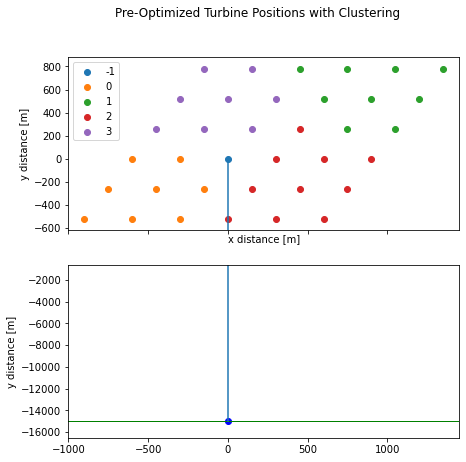

In [374]:
#CLUSTERING ALGORITHM

#Uses an adapted version of kmeans with a cap on the number of points per cluster. Used to radially cluster turbines
#into segments which MST algorithm can then use to determine cabling for a given radial array. Initially unnecessary
#for the initially structured turbine layout as seen above, but increasingly important as turbine layout becomes
#non-uniform through optimisation when the below function is repeatedly called.
# minsize_kmeans imported from external python file

def clustering_algorithm(positionlist,nturb,maxnodespertree):
    k = math.ceil(nturb/maxnodespertree) #number of clusters. math.ceil rounds a number upwards to its nearest integer
    [turbines, centres] = minsize_kmeans(positionlist[1:,:] ,k ,min_size = 1, max_size = maxnodespertree) 
    #turbines exists as an array containing the cluster value for each turbine
    #Assigns each turbine to a cluster. excludes substation, executes external python file, 
    #limits for how many turbines are in each cluster between 1 and max nodes per tree 
    label = np.concatenate((np.array([-1]),turbines)) # Adds -1 (substation label) to the other turbine labels
    u_labels = np.unique(label) 
    # finds unique elements of label. Finds the unique cluster labels 
    # each turbine is assigned a cluster/label and this returns a single label for each cluster
    
    a = 0
    indiceslist = np.empty((k,maxnodespertree), dtype=np.int8) # empty array of no.clusters by max nodes per tree
# indiceslist basically tells us what turbines belong to each cluster
# each row of indiceslist represents a cluster and each point on that row a indidual turbine within that cluster
# Each row starts with a 0 which represents the subsation which belongs to all clusters
# As seen before in the initial layout numbers are assigned starting at 1 which is the turbine (a,0) from the substation
# The numbering then continues in a cyclic motion traveling anticlockwise up until the total number of turbines
    
    for i in range(k): # loops for number of clusters
        indices = [i for i, x in enumerate(label) if x == a] # enumerate exists as a counter in the loop (starts at x=a=0)

        if len(indices) < maxnodespertree:
            noofemptys = maxnodespertree - len(indices)
            for l in range(noofemptys): # For the empty spaces in the matrix replaces these with -100 as fillers
                indices.append(int(-100))
    
        indiceslist[i,:] = (indices)
        a += 1
    
    arr = np.zeros((k,1),dtype=np.int8)   # zero array of number of clusters by 1 (Substation array)
    indiceslist = np.concatenate((arr,indiceslist),axis=1) # Adds substation zero array to turbine cluster matrix
    return indiceslist,u_labels,label

t1_start = perf_counter() # Starts timer
indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree) #Executes clustering algorithm
t1_stop = perf_counter() # Ends timer
print('Function run time:', t1_stop-t1_start) # Prints algorithm run time

fig, (ax1,ax2) = plt.subplots(2,sharex=True,figsize=(7,7))
fig.suptitle('Pre-Optimized Turbine Positions with Clustering')

#Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)
for i in u_labels: # loops for number of turbines
    ax1.scatter(positionlist[label == i , 0] , positionlist[label == i, 1] , label = i)
ax1.legend() # prints legend
ax1.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax1.set_xlabel('x distance [m]') # x axis label
ax1.set_ylabel('y distance [m]') # y axis label
ax1.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax1.set_ylim([min(positionlist[:,1])-100, max(positionlist[:,1])+100]) #y limits 

#Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
ax2.scatter(OnshoreSubstation[0],OnshoreSubstation[1],c='blue') #onshore substation
ax2.plot(TXShoreLine,TYShoreLine,c='green',linewidth=1) #Produces line representing the shore line in green
ax2.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax2.set_ylabel('y distance [m]') # y axis label
ax2.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax2.set_ylim([min(positionlist[:,1])-DistanceToShore-1000, min(positionlist[:,1])-100]) #y limits

print(indiceslist)

In [375]:
#CREATES INPUT NEEDED FOR MST ONCE CLUSTERS ARE DEFINED.

#distance_global - distances of each turbine with respect to the substation and each other h=sqrt(x^2+y^2)
#e.g. row 0 would be each turbines distance with respect to the substation
# and row 4 would be each turbines distance with respect to the 4th turbine as found in the position list
# distance_globl[i,i] = 1e10 since this is the distance of each turbine with respect to itself so we want the MST to ignore thse values
#angle_global - angle of each turbine with respect to the substation and each other arctan(y/x)
#distance and angle then do something similar but considering the cluster formations as well

def geom_analysis(positionlist,indiceslist):
    
    #Arrays for pairwise distances and angles
    #Angle 0: x directıon. Angle pi/2: y directıon
    distance = [None] * math.ceil(nturb/maxnodespertree) # null array with size based on number of clusters
    angle = [None] * math.ceil(nturb/maxnodespertree) 
    distance_global = np.zeros((nturb,nturb)) #zero array nturb by nturb. This will be for storing the distance between each pair of turbines for cabling
    angle_global = np.zeros((nturb,nturb)) # Like above this will be for storing the angle data between each pair of turbines for cabling
    coords = positionlist[1:,:] # Coordinates of each turbine

    for i in range(0,nturb): # loops for number of turbines
        distance_global[i,:]=np.sqrt(np.square(coords[i,0]-coords[:,0])+np.square(coords[i,1]-coords[:,1])) # Pythagoras for hypotenuse
        angle_global[i,:]=np.arctan2(coords[:,1]-coords[i,1],coords[:,0]-coords[i,0]) #Pythagoras for angle
        distance_global[i,i]=1e10
        #Rotate angles so that north=0 and convert to degrees
    angle_global=-np.rad2deg(angle_global)+270
    
    for x in range(0,math.ceil(nturb/maxnodespertree)): # loops for number of clusters
        nturbintree = np.count_nonzero(indiceslist[x,:] > -1) # Everything except the -100 ones which were denoted earlier to show that there is no turbine at that index
        distance[x]=np.zeros((nturbintree,nturbintree))
        angle[x]=np.zeros((nturbintree,nturbintree))
    
        for i in range(0,nturbintree):
            for j in range(0,nturbintree):
                distance[x][i,j] = np.sqrt(np.square(positionlist[(indiceslist[x,i]),0]-positionlist[(indiceslist[x,j]),0]) + np.square(positionlist[(indiceslist[x,i]),1]-positionlist[(indiceslist[x,j]),1]))
                angle[x][i,j]=np.arctan2(positionlist[(indiceslist[x,j]),1]-positionlist[(indiceslist[x,i]),1],positionlist[(indiceslist[x,j]),0]-positionlist[(indiceslist[x,i]),0])
                distance[x][i,i]=1e10
        
        #Rotate angles so that north=0 and convert to degrees
        angle[x]=-np.rad2deg(angle[x])+270
      
    return distance,angle,distance_global,angle_global

In [376]:
# DETERMINES MINIMUM LENGTH OF CABLING REQUIRED TO CREATE COMPLETE CABLING NETWORK SUCH THAT ALL TURINES ARE CONNECTED
# IN ACCORDANCE WITH USER'S CONDITIONS.

def Minimum_Spanning_Tree(distance,indiceslist):

    MSTweight = [None] * math.ceil(nturb/maxnodespertree) # null array with sized based on number of clusters
   
    for x in range(0,math.ceil(nturb/maxnodespertree)): #loops for number of clusters
        nturbintree = np.count_nonzero(indiceslist[x,:] > -1)
        g=Graph(nturbintree) #Graph is part of the external python script titled Boruvka_Mod
        
        for i in range(0,nturbintree):
            for j in range(i+1,nturbintree):
                g.addEdge(i,j ,(distance[x][i,j]*1000))
           
        MSTweight[x]=g.boruvkaMST()
    return MSTweight

Each tree weight tree 1 2400000.0
Each tree weight tree 2 3193725.393319377
Each tree weight tree 3 3000000.0
Each tree weight tree 4 2400000.0
MST total weight 10993725.393319378 m


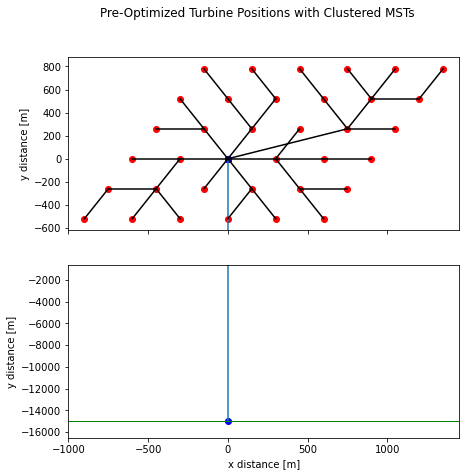

In [377]:
#PLOTTING PRE-OPTIMISED MST

# the Boruvka_mod code requires graphs with vertices 0....n, which is provided by the index value on indices list.
# When this is plotted, the values within the correct indiceslist row are then used to reference the index within
# positionlist to be plotted.

#

MSTweight=Minimum_Spanning_Tree(geom_analysis(positionlist, indiceslist)[0],indiceslist)

fig, (ax1,ax2) = plt.subplots(2,sharex=True,figsize=(7,7))
fig.suptitle('Pre-Optimized Turbine Positions with Clustered MSTs')

#Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)
ax1.scatter(positionlist[:,0],positionlist[:,1],c='red') # Prints turbine positions in red
ax1.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax1.set_ylabel('y distance [m]') # y axis label
ax1.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax1.set_ylim([min(positionlist[:,1])-100, max(positionlist[:,1])+100]) #y limits 

#Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
ax2.scatter(OnshoreSubstation[0],OnshoreSubstation[1],c='blue') #onshore substation
ax2.plot(TXShoreLine,TYShoreLine,c='green',linewidth=1) #Produces line representing the shore line in green
ax2.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax2.set_xlabel('x distance [m]') # x axis label
ax2.set_ylabel('y distance [m]') # y axis label
ax2.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax2.set_ylim([min(positionlist[:,1])-DistanceToShore-1000, min(positionlist[:,1])-100]) #y limits

links = [None] * math.ceil(nturb/maxnodespertree)
MSTWeightSum = 0 #MST weight is simply the total length of cabling used

for a in range(0,math.ceil(nturb/maxnodespertree)):
    MSTWeightSum += MSTweight[a][0]
    print('Each tree weight', 'tree',a+1 ,MSTweight[a][0])
    links[a] = MSTweight[a][1]
    
    for b in links[a]:
        u = positionlist[(indiceslist[a,b[0]])][0], positionlist[(indiceslist[a,b[1]])][0]
        v = positionlist[(indiceslist[a,b[0]])][1], positionlist[(indiceslist[a,b[1]])][1]
        ax1.plot(u,v, c='black')
        ax1.scatter(positionlist[0,0],positionlist[0,1],c='blue')
        
print('MST total weight', MSTWeightSum, 'm')

In [378]:
#DISPLAYS RAW BATHYMETRY DATA

#print(data) # Prints out bathymetry data - Read in using pandas in previous section

In [379]:
#CONVERTS LATITUDE AND LONGITUDE IN BATHYMETRY DATA TO CENTERED EASTINGS AND NORTHINGS

data['easting'] = data.apply(lambda row: utm.from_latlon(row['LAT'], row['LON'])[0], axis=1) #Converts lon/lat to easting and adds this onto the 'data' file
data['northing'] = data.apply(lambda row: utm.from_latlon(row['LAT'], row['LON'])[1], axis=1) #Converts lon/lat to northing and adds this onto the 'data' file

zero_east = min(data['easting']) + (max(data['easting']) - min(data['easting']))/2 +30000 # Determines centre of bathymrtry data in easting direction (+30,000 is simply to get a more interesting result from the current bathymetry data)
zero_north = min(data['northing']) + (max(data['northing']) - min(data['northing']))/2 # Determines centre of bathymetry data in northing direction   

data['centered_easting'] = data['easting'] - zero_east # Centres the data about (0,0) and adds this onto the 'data' file
data['centered_northing'] = data['northing'] - zero_north # Centres the data about (0,0) and adds this onto the 'data' file

#print(data) 

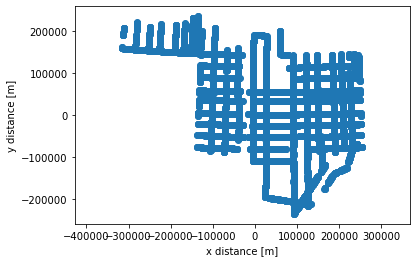

In [380]:
#PLOTS CENTERED BATHYMETRY DATA

fig, ax = plt.subplots()
plt.axis('equal')
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
ax.scatter(data['centered_easting'],data['centered_northing'])
plt.show()

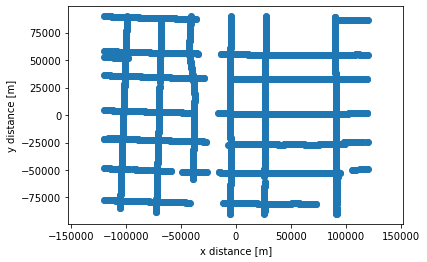

In [381]:
# SAMPLING AND PLOTTING CENTRAL BATHYMETRY DATA
# Takes sample between +/-120000 in easting direction, +/-90000 in the northing direction, and +/-1000 for the depth values

fig, ax = plt.subplots()
plt.axis('equal')
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
data = data[(data['centered_easting'] >=-120000) & (data['centered_easting'] <= 120000) & (data['centered_northing']>=-90000) & (data['centered_northing']<= 90000) & (data['CORR_DEPTH']<=1000) & (data['CORR_DEPTH']>=-1000)]
ax.scatter(data['centered_easting'],data['centered_northing'])
plt.show()

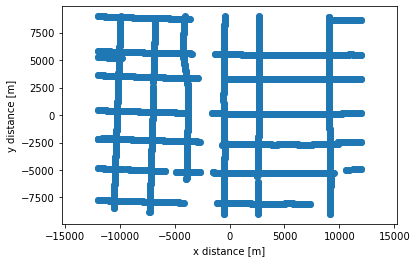

In [382]:
#FURTHER BATHYMETRY DATA PROCESSING
#Further decreases the area considered to be more applicable to the size of the wind farm (Sample from before divided by 10 in northing and easting directions)

fig, ax = plt.subplots()
plt.axis('equal')
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
data['centered_easting'] = data['centered_easting']/10
data['centered_northing'] = data['centered_northing']/10
ax.scatter(data['centered_easting'],data['centered_northing'])
plt.show()

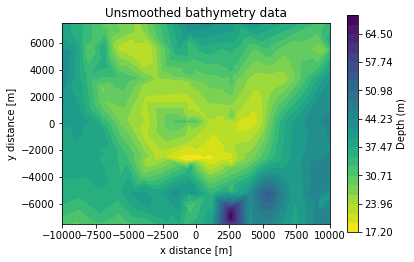

In [383]:
#UNSMOOTHED BATHYMETRY DATA CONTOUR PLOTTING

fig, ax = plt.subplots()
plt.xlim([-10000, 10000]) # x Limits of plot between +/-10000
plt.ylim([-7500, 7500]) # y Limits of plot between +/-7500
ax.set_aspect(aspect=1) # Sets the aspect of the axis scaling, i.e. the ratio of y-unit to x-unit.
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')

maxdepth = max(data['CORR_DEPTH'])
levels = np.linspace(mindepth,maxdepth,24) # Creates 24 even spaces or levels between the min and max depth

tcf = ax.tricontourf(data['centered_easting'], data['centered_northing'], data['CORR_DEPTH'], levels=levels, cmap = 'viridis_r') # (x,y,colour bar factor,level values,colour scale)
cbar = plt.colorbar(tcf)
cbar.set_label('Depth (m)')
ax.set_title('Unsmoothed bathymetry data');

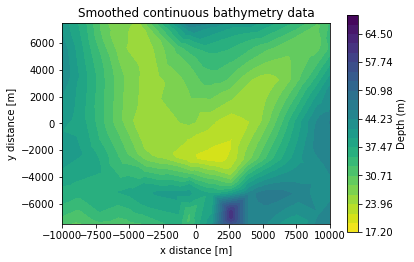

In [384]:
#SMOOTHING BATHYMETRY DATA

smooth = spline.SmoothBivariateSpline(data['centered_easting'], data['centered_northing'], data['CORR_DEPTH'], s = 25000)

fig, ax = plt.subplots()
plt.xlim([-10000, 10000])
plt.ylim([-7500, 7500])
ax.set_aspect(aspect=1)
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
levels = np.linspace(mindepth,maxdepth,24)

tcf = ax.tricontourf(data['centered_easting'], data['centered_northing'], smooth(data['centered_easting'], data['centered_northing'], grid=False), levels=levels, cmap = 'viridis_r')
cbar = plt.colorbar(tcf)
cbar.set_label('Depth (m)')
ax.set_title('Smoothed continuous bathymetry data');

In [385]:
# DETERMINING DEPTH AND ASSOCIATED COST FOR EACH TURBINE

def depthvalues(positionlist):
    DepthPerTurbine = [None] * (len(positionlist)-1) # none defines a null/no value. Get a null list the size of the np. turbines
    DepthCostPerTurbine = [None] * (len(positionlist)-1) # Get a null list the size of the number of turbines
    DepthCostAllTurbines = np.float64(0) # Assigns initial value to variable

    for i in range(0,len(positionlist)-1): # loops for amount of turbines
        DepthPerTurbine[i] = spline.SmoothBivariateSpline.ev(smooth, positionlist[i+1,0], positionlist[i+1,1]) # Acquires depth assigned to each turbines position (x,y)
        DepthCostPerTurbine[i] = MinDepthCostPerTurbine = CostperTurbine*(0.0002*(float(DepthPerTurbine[i])**2) - 0.0002*(float(DepthPerTurbine[i])) + 0.9459)-CostperTurbine #Formula for depth cost
        DepthCostAllTurbines += DepthCostPerTurbine[i] # Sums up all turbines depth costs
        
    mindepth=float(min(DepthPerTurbine))
    maxdepth=float(max(DepthPerTurbine))
    return DepthCostAllTurbines, mindepth, maxdepth # returns respective values to user

depthvalues(positionlist)

(5670839.477005682, 23.7892128854861, 27.226066356920597)

In [386]:
smooth

In [387]:
#SETTING MODEL PARAMETERS

v0=8.0  #Incoming wind speed
nwind = 33
wind=np.arange(254,287)

#b=np.array((1,5,1000))
#b=np.array(( 1.40002561e-01,   8.51478121e+00,   2.62606729e+03))

# 3 model parameters below:

# 0th: how much power the turbine removes at the centre of the peak of the power distribution.
# 1st: how wide the angle of effect is. UNITS: degrees
# 2nd: up to how far back the effect takes place (approx. 2.6km) UNITS: [m]

model=np.array((1.39998719e-01, 8.51483871e+00, 2.62613638e+03))

ws=2.0 #weibull scale factor
wei_gamma=gamma(1.+1./ws)

Pr = 2*10**6 #Rated Power for Horns Rev 1 Turbines. Max power output [Watts]
Vc = 4.0 #Cut-in Velocity. Starts producing energy at wind speed of 4m/s [m/s]
Vr = 15.0 #Rated Velocity. Starts producing max energy at 15m/s
Vf = 25.0 #Cut-off Velocity. Turbines cut out at wind speeds of 25m/s to prevent damage to the turbines.
k = 2.0 #Weibull shape parameter
(Pr,Vc,Vr,k)

#interpolation parameters
dvel=1.5 #[m/s]
dang=30. #[degrees]

In [388]:
#DETERMINING WIND DIRECTION AND VELOCITY AT HORNS REV 1

v=np.loadtxt('hornsrev_data_all.txt') # assigns data to variable v.
vxref=v[:,3] # (INDEXING STARTS FROM 0). Third column of data is velocity of wind in x direction.
vyref=v[:,4] # (INDEXING STARTS FROM 0). Fourth column of data is velocity of wind in y direction.
angles=v[:,0] # Zeroth column of data is wind angle.
vmean=np.sqrt(np.square(vxref)+np.square(vyref)) # Uses pythagoras to find the wind magnitude + direction for each location.

vmean=pd.DataFrame(vmean) # organises vmean into labelled data structure
vref=pd.DataFrame()

vmean['angle']=angles # add another column to vmean (angle)
vref=vref.append(vmean) # add empty pandas data frame

vref=vref.groupby('angle')
vref.groups
vref.describe()
vref.get_group(260).iat[50,0] # data manipulation to group by angle etc.

6.512913707119303

In [389]:
#Arrays for pairwise distances and angles
#Angle 0: x direction. Angle pi/2: y directıon

# calculates distance and angle between each pair of turbines:

distance=np.zeros((nturb,nturb)) # 2x2 matrix of distances between turbines i and j where distance i-i and distance j-j = 0
# as they're distances to themselves: i-i i-j
                                 #    j-i j-j

angle=np.zeros((nturb,nturb)) # same as above but for angles between turbines.

for i in range(0,nturb):
   
    # 80x80 matrices as there's 80 turbines at Horns Rev 1.
    # squares y distance and x distance then sqrt to find overall distance between 2 turbines.
    distance[i,:]=np.sqrt(np.square(positionlist[i+1,0]-positionlist[1:,0])+np.square(positionlist[i+1,1]-positionlist[1:,1]))
    # same as above using arctan2 whilst giving correct quadrant (between 2 turbines).
    angle[i,:]=np.arctan2(positionlist[1:,1]-positionlist[i+1,1],positionlist[1:,0]-positionlist[i+1,0])
# Rotate angles so that north=0 and convert to degrees (and clockwise instead of anticlockwise)
angle=-np.rad2deg(angle)+270

# Rotating angles to wind direction
windangle=30 # degrees
rotangles=np.mod(angle-windangle+180,360)-180

In [390]:
# IMPORTING WIND DIRECTION DATA

#meteorological data where north = 0 degrees)
directiondata = pd.read_csv ('Directiondata.csv')
print (directiondata)
# velocity is the mean velocity with which wind from this direction blows
# c determines how wide the distribution is
# frequency/100 determines how often the wind is blowing at this angle

    Angle  Velocity     c  frequency
0       0      8.89  2.09       4.82
1      30      9.27  2.13       4.06
2      60      8.23  2.29       3.59
3      90      9.78  2.30       5.27
4     120     11.64  2.67       9.12
5     150     11.03  2.45       6.97
6     180     11.50  2.51       9.17
7     210     11.92  2.40      11.84
8     240     11.49  2.35      12.41
9     270     11.08  2.27      11.34
10    300     11.34  2.24      11.70
11    330     10.79  2.19       9.69
12    360      8.89  2.09       4.82


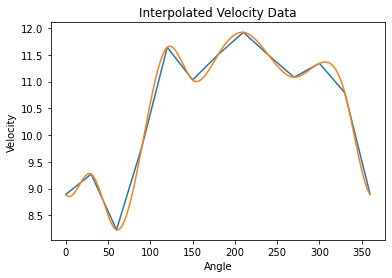

In [391]:
# interpolate 'velocity'
# info is only given every 30 degrees, giving a 'step function'
# interpolation gives higher resolution
# function is periodic as 360deg is the same as 0deg.
x = directiondata['Angle']
y = directiondata['Velocity']
wbvel = SP (x, y,bc_type='periodic')
xs = np.arange(0, 360,0.10)
plt.plot(x,y, label='Line')
plt.plot(xs, wbvel(xs), label="Interpolated line ")
plt.title('Interpolated Velocity Data')
plt.xlabel('Angle')
plt.ylabel('Velocity')
plt.show()
# blue lines shows linear interpolation, orange shows smooth interpolation including across the
# periodic boundary.

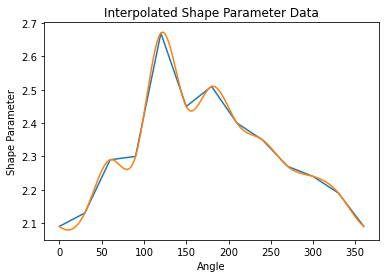

In [392]:
#interpolate 'c'
# info is only given every 30 degrees, giving a 'step function'
# interpolation gives higher resolution
# function is periodic as 360deg is the same as 0deg.
x = directiondata['Angle']
y = directiondata['c']
wbshape = SP (x, y,bc_type='periodic')
xs = np.arange(0, 360, 0.1)
plt.plot(x,y)
plt.plot(xs, wbshape(xs), label="S")
plt.title('Interpolated Shape Parameter Data')
plt.xlabel('Angle')
plt.ylabel('Shape Parameter')
plt.show()

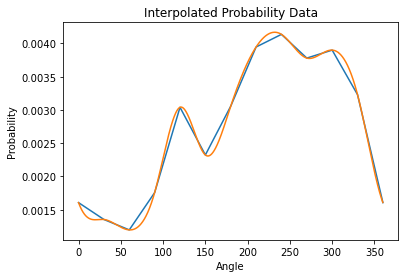

In [393]:
#interpolate 'frequency'
# info is only given every 30 degrees, giving a 'step function'
# interpolation gives higher resolution
# function is periodic as 360deg is the same as 0deg.
x = directiondata['Angle']
y = directiondata['frequency']/(100.*30.) #Data is in percent per 30 degrees, changing to probability per degree


windfreq = SP (x, y,bc_type='periodic')
xs = np.arange(0, 360, 0.1)
plt.plot(x,y)
plt.plot(xs, windfreq(xs), label="S")
plt.title('Interpolated Probability Data')
plt.xlabel('Angle')
plt.ylabel('Probability')
plt.show()
# plot shows wind direction is predominantly 200-320deg.

In [394]:
# Simple Attenuation fn
# Determines how much wind there is AFTER a turbine.
def att(dist, ang, model): 
        # 'Model' parameters are defined in 2ND CELL.

    # angular part
    angular=np.where(2.*model[1]*np.abs(ang)<np.pi,np.square(np.cos(model[1]*ang)),0.)
    # angular = np.cos(model[1]*ang WHEN 2.*model[1]*np.abs(ang) is less than pi, else angular = 0.
    
    # radial part (distance) (Gaussian Function)
    radial=np.exp(-np.square(dist/model[2])) # decreasing exponential of square, scaled by 2nd parameter
    penalty=np.exp(-np.square(dist/200))
    #penalty = 0
    return 1.0-1*model[0]*angular*radial-2*model[0]*penalty # OUTCOME

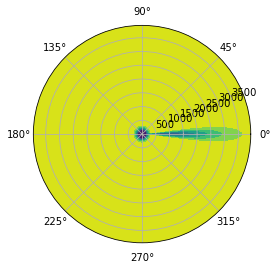

0.580003843


In [395]:
azimuths = np.radians(np.linspace(0, 360, 360)) # angles theta from 0 to 360 degress in 1 degree increments. Grid
zeniths = np.arange(0, 4000, 50) # distance from 0 to 4000 broken up into increments of 50.

r, theta = np.meshgrid(zeniths, azimuths)
values = att(r,np.mod(theta+np.pi,np.pi*2)-np.pi,model) # gets angles from -pi to pi, not from 0 to 2pi.

fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
ax.contourf(theta, r, np.maximum(values,0.85*np.ones(np.shape(values))))

plt.show()
print(np.min(values))

## Cell description:
# Polar plot is for 1 turbine, blue area shows where wind speed is affected. (Numbers label distance from turbine).
# Across the curve the distribution is the hump of cosine^2 function.
# Radially the distribution shown is Gaussian.
# Wake is currently too narrow close to the turbine as it treats the turbine as a point rather than accommodating
# for the blades' diameter.

In [396]:
# # isn't useful for continuing code, just rotates the windfarm.
# def rotate(angle,coords):
#     angle = np.pi*angle/180.
#     rotcoordx = []
#     rotcoordy = []
#     for coord in coords:
#         rotcoordx+=[coord[0]*np.cos(angle)-coord[1]*np.sin(angle)]
#         rotcoordy+=[coord[0]*np.sin(angle)+coord[1]*np.cos(angle)]
#     rotcoords=[rotcoordx,rotcoordy]
#     rotcoords=np.array(rotcoords).T   
#     return rotcoords 
# #print rotate(254,coords)[:,0]
# plt.scatter(rotate(0,coords)[:,0],rotate(0,coords)[:,1])

In [397]:
# returning total deviation between model and training set (between CFD data and the attenuation model)
# This was relevant for earlier stages of the project when the wake model was being developed
#Total att
def deviation(b):
    total_att=np.ones((nturb,nwind))
    deviation=0
    for k in range(0,nwind):
        for j in range(0,nturb):
            for i in range(0,nturb):
                if (i!=j):
                    total_att[j,k] = total_att[j,k]*att(distance[i,j],np.mod(np.deg2rad(angle[i,j]-wind[k])+np.pi,np.pi*2)-np.pi,b)
 #           print('{0} {1} {2}'.format(j,wind[k],total_att[j,k]))
            deviation=deviation+np.square(vref.get_group(wind[k]).iat[j,0]-v0*total_att[j,k])
    return deviation

In [398]:
# returning deviation for each turbine.
# This was relevant for earlier stages of the project when the wake model was being developed
#Total att
def deviation_sq(model):
    total_att=np.ones((nturb,nwind))
    dev_vec=np.zeros((nturb*nwind))
    for k in range(0,nwind):
        for j in range(0,nturb):
            for i in range(0,nturb):
                if (i!=j):
                    total_att[j,k] = total_att[j,k]* att(distance[i,j],np.mod(np.deg2rad(angle[i,j]-wind[k])+np.pi,np.pi*2)-np.pi,model)
 #           print('{0} {1} {2}'.format(j,wind[k],total_att[j,k]))
            dev_vec[nturb*k+j]=(vref.get_group(wind[k]).iat[j,0]-v0*total_att[j,k])
    return dev_vec

In [399]:
## (USED IN TARGET FUNC)
# Calculates the power produced by turbines when it sees a certain wind speed at a certain angle. 3D matrix
def power(wsr,v): # wind speed reduction, velocity
    nvel=np.size(v)
    nangle=np.size(wsr,1)
    power_vec=np.zeros((nturb,nangle,nvel))
    power_vec=POvec(np.outer(wsr,v)).reshape(nturb,nangle,nvel) # np.outer takes every wsr element and individually multiplies it with every element of v.
    return power_vec

In [400]:
## GIVES PROBABILITY OF WIND SPEED V AT A GIVEN ANGLE
def windspeedprobability(angles,v,d_angle,d_vel):
    nvel=np.size(v) 
    nangle=np.size(angles)
    wsprob=np.zeros((nangle,nvel))
    for i in range(angles.shape[0]):
        # Get Weibull parameters for angle and evaluate probability
        wsprob[i,:]=(wei(v[:],wbvel(angles[i]),wbshape(angles[i])))*windfreq(angles[i])*d_angle*d_vel
    return wsprob

In [401]:
# DEFINES WEIBULL DISTRIBUTION (shows the probability of any given wind speed occuring).

def wei(x,n,k): # convention to have in this order, scale parameter comes first (x) 
    u=n/gamma(1+1/k) #scaled wind speed
    return (k / u) * (x / u)**(k - 1) * np.exp(-(x / u)**k)
# k = Weibull shape parameter
# n = scale parameter
# x= value we are valuating

In [402]:
def wind_dist(v,vm):
    return wei(v,vm,k)

In [403]:
wind_dist(1.0,v0)

0.024244336764100854

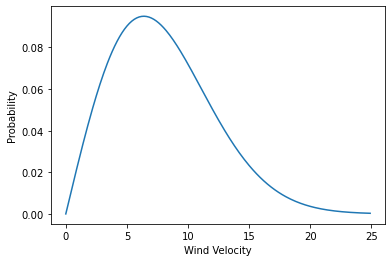

In [404]:
# PLOTS WEIBULL DISTRIBUTION

x=np.arange(0,25,0.1)
y=wind_dist(x,v0)

plt.xlabel('Wind Velocity')
plt.ylabel('Probability')
plt.plot(x,y)

In [405]:
velocities=np.arange(Vc,Vf,dvel) # 1D array ranging from Vc to Vf in dvel intervals. 4 to 25 in steps of 1.5
angles=np.arange(0,360,dang) # 0 to 360 with intervals of dang.
wsp=windspeedprobability(angles,velocities,dang,dvel) # tells probability of getting wind from a certain direction with a certain velocity.
# sum of all numbers would add up to 1.
print(wsp,np.shape(wsp),np.sum(wsp)) # wsp array, shape of wsp (rows,columns), sum of wsp elements
print(np.shape(velocities)) # shape of velocities array (rows, columns)
#plt.plot(x,y)
print(angles)
print(velocities)
print(dang)

[[4.77182096e-03 5.88022006e-03 6.34735626e-03 6.19662705e-03
  5.55875083e-03 4.62317247e-03 3.58437384e-03 2.59971881e-03
  1.76810109e-03 1.12944774e-03 6.78429815e-04 3.83514485e-04
  2.04152332e-04 1.02378274e-04]
 [3.67387090e-03 4.64608292e-03 5.14504014e-03 5.15534975e-03
  4.75022222e-03 4.06131175e-03 3.23944001e-03 2.41890313e-03
  1.69470140e-03 1.11571441e-03 6.90948093e-04 4.02785646e-04
  2.21127127e-04 1.14361844e-04]
 [3.87113306e-03 4.99524612e-03 5.46113005e-03 5.23465968e-03
  4.46882703e-03 3.42448739e-03 2.36490832e-03 1.47456723e-03
  8.30691743e-04 4.22784591e-04 1.94305505e-04 8.05741367e-05
  3.01181610e-05 1.01370030e-05]
 [3.99467844e-03 5.44323370e-03 6.41457656e-03 6.77712380e-03
  6.52991173e-03 5.78970962e-03 4.74739637e-03 3.61005399e-03
  2.54967320e-03 1.67370059e-03 1.02137095e-03 5.79358036e-04
  3.05363013e-04 1.49476689e-04]
 [3.69092665e-03 5.93690526e-03 8.12335243e-03 9.88845861e-03
  1.09285582e-02 1.10735770e-02 1.03342631e-02 8.89747375e-03


In [406]:
# CALCULATES THE POWER CURVE OF A TURBINE

# Plots the power curve of a turbine.
# No power output from 0-4m/s, then cubic rise up to 15m/s and stays
# constant until cut-off velocity of 25m/s.

#cubic Based Power output
a=Pr/(Vr**3-Vc**3)
b=Vc**3/(Vr**3-Vc**3)

def q(v): # q is power output

    if (v<Vc): # below cut in velocity power is 0.
        q=0
    elif (v<Vr):
        q=a*v**3-b*Pr # cubic power output between cut in and max.
    elif (v<Vf):
        q=Pr # max power between max and cut off velocity.
    else: 
        q=0 # no power above cut off velocity.
    return q

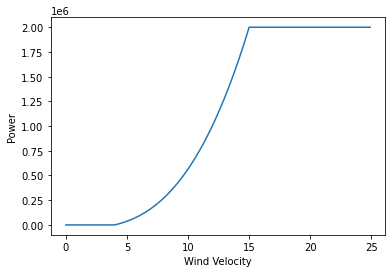

In [407]:
#PLOTS TURBINE POWER CURVE

x=np.arange(0,25,0.1)
POvec=np.vectorize(q) # vectorises power output function q (from cell above).
y=POvec(x)

plt.xlabel('Wind Velocity')
plt.ylabel('Power')
plt.plot(x,y)

In [408]:
# EXPECTED TURBINE OUTPUT (Watts) for the given wind distribution and positions.
# Can be seen that top left (NW) produces most energy for Horns Rev 1 Wind Farm.

# EXPECTED POWER FROM WIND FARM CALCULATIONS
# multiply the power that you'd get for each wind angle and speed condition by the probability of this occuring, for all angles and speed
# values and sum to find the expected power.
# Sum up this value for all turbines to find total wind farm expected power output.
# output=np.zeros((nturb)) 
# output=np.tensordot(powout,wsp,2)
# print(output,np.shape(output),np.sum(output))
# last output is total power output in Watts.

In [409]:
# TURBINE OUTPUT (Watts) WITH NO INTERFERENCE

#Reference output:
# Same calculations as cell above except each turbine sees the full amount of wind every time
# (i.e. no wind reduction from other turbines).
refpowout=power(np.ones((nturb,np.size(angles))),velocities)
refoutput=np.zeros((nturb))
refoutput=np.tensordot(refpowout,wsp,axes=2)
print(refoutput,np.shape(refoutput),np.sum(refoutput))

# last output is total power output in Watts.

[868043.68973916 868043.68973916 868043.68973916 868043.68973916
 868043.68973916 868043.68973916 868043.68973916 868043.68973916
 868043.68973916 868043.68973916 868043.68973916 868043.68973916
 868043.68973916 868043.68973916 868043.68973916 868043.68973916
 868043.68973916 868043.68973916 868043.68973916 868043.68973916
 868043.68973916 868043.68973916 868043.68973916 868043.68973916
 868043.68973916 868043.68973916 868043.68973916 868043.68973916
 868043.68973916 868043.68973916 868043.68973916 868043.68973916
 868043.68973916 868043.68973916 868043.68973916] (35,) 30381529.14087047


In [410]:
# # assigns smaller interpolation intervals to dvel and dang to compare to coarser interpolations.
# dvel=0.1
# dang=0.1
# velocities=np.arange(Vc,Vf+dvel,dvel)
# angles=np.arange(0,360,dang)
# wsp=windspeedprobability(angles,velocities,dang,dvel)
# wsr=windspeedreduction(distance,angle,angles,model)
# powout=power(wsr,velocities)
# output=np.zeros((nturb)) 
# output=np.tensordot(powout,wsp,2)
# print (dvel,dang,np.sum(output))
# fineout=output

In [411]:
# # Calculates RMS error from changing interpolation value.
# velarray=np.array([1.5])
# angarray=np.array([5])
# rmserror=np.zeros((np.size(velarray),np.size(angarray)))
# i=0
# for dvel in velarray:
#     j=0
#     for dang in angarray:
#         velocities=np.arange(Vc,Vf+dvel,dvel)
#         angles=np.arange(0,360,dang)
#         wsp=windspeedprobability(angles,velocities,dang,dvel)
#         wsr=windspeedreduction(distance,angle,angles,model)
#         powout=power(wsr,velocities)
#         output=np.zeros((nturb)) 
#         output=np.tensordot(powout,wsp,2)
#         rmserror[i,j]=np.sqrt(np.sum(np.square(output-fineout))/np.size(output))
#         print (dvel,dang,np.sum(output),rmserror[i,j])
#         j+=1
#     i+=1
# print(rmserror)

In [412]:
## IMPORTING WIND DIRECTION DATA
## north = 0 degrees
direction_data = pd.read_csv('Directiondata.csv')
wind_directions = directiondata['Angle']
wind_directions = pd.DataFrame(wind_directions).to_numpy()
wind_directions = np.transpose(wind_directions)

In [413]:
# FUNCTION: SIMPLE ROTATE
def rotate(angle,coords):
    angle = np.pi*angle/180.
    rotcoordx = []
    rotcoordy = []
    for coord in coords:
        rotcoordx+=[coord[0]*np.cos(angle)-coord[1]*np.sin(angle)]
        rotcoordy+=[coord[0]*np.sin(angle)+coord[1]*np.cos(angle)]
    rotcoords=[rotcoordx,rotcoordy]
    rotcoords=np.array(rotcoords).T
    return rotcoords

In [414]:
# TRAIN MODEL and assign to predicting class
name = "all_dataset.csv"
training_class = GP_train() # create training class
training_model = training_class.train_model() # trains model on "all_dataset.csv"

# CREATE PREDICTING CLASS from which attenuation predictions are made
predict_class = GP_predict(training_model) # create predicting class

In [415]:
## OLD WINDSPEED REDUCTION FUNCTION (USED IN TARGET FUNC)
## description: calculates the % of wind that arrives at a turbine for a certain angle.
## Starts with assumption that there's zero wake so all turbines get full wind.
def windspeedreduction_old(distance,angle,direction,model): # vectors
    ndir=np.size(direction)
    total_att=np.ones((nturb,ndir)) # as many rows as there are turbines, as many columns as there are wind directions.
 #   power_vec=np.zeros((nturb,ndir))
    for j in range(0,nturb):
        for i in range(0,nturb):
            if (i!=j):
                # compounding wind speed reductions
                total_att[j,:] = total_att[j,:]* att(distance[i,j],np.mod(np.deg2rad(angle[i,j]-direction[:])+np.pi,np.pi*2)-np.pi,model)
  #      power_vec[j,:]=(v0*total_att[j,:])**3
    return total_att # matrix output that's needed. n turbine rows, n direction columns.
                     # Tells how much of 100% of wind arrives at a certain turbine from a certain direction.
    
## TESTING   
distance,angle,distance_global,angle_global = geom_analysis(positionlist,indiceslist)
print(f'OLD WSR')
print(f'positionlist.shape = {positionlist.shape}')

print(f'angles.shape = {angles.shape}     (number of wind angles!)')
wsr=windspeedreduction_old(distance_global,angle_global,angles,model) ## old WSR function
# np.set_printoptions(threshold=np.inf)
# print(f'wsr = \n{wsr}')
# np.set_printoptions(threshold=1000)
print(f'type(wsr) = {type(wsr)}\nwsr.shape = {wsr.shape}\nCONCLUSION: the first dimension (y = {wsr.shape[0]}) is nturb, the second dimension (x = {wsr.shape[1]}) is ndir')

OLD WSR
positionlist.shape = (36, 2)
angles.shape = (12,)     (number of wind angles!)
type(wsr) = <class 'numpy.ndarray'>
wsr.shape = (35, 12)
CONCLUSION: the first dimension (y = 35) is nturb, the second dimension (x = 12) is ndir


In [416]:
## FUNCTION: WIND SPEED REDUCTION (WSR) (NEW!)
## description: returns a matrix of wind attenuation with nturb turbine rows, ndir direction columns
def windspeedreduction(positionlist,directions,g_model):
    ndir = int(np.size(directions))
    nturb = int(np.size(positionlist)/2)
    total_att=np.ones((nturb,ndir))
    for i in range(0,ndir):
        angle_to_rotate = 90 + directions[i];
        westerly_pos_list = rotate(angle_to_rotate,positionlist) # rotate position list for westerly wind
        att_vector = g_model.predict(westerly_pos_list, nturb) # vector of attenuations (from GP_functions module)
        att_vector = att_vector.reshape(nturb,)
#         print(f'positionlist.shape = {positionlist.shape}')
#         print(f'ndir = {ndir}')
#         print(f'att_vector.shape = {att_vector.shape}')
#         print(f'total_att.shape = {total_att.shape}')
#         print(f'total_att[:,i].shape = {total_att[:,i].shape}')
        total_att[:,i] = att_vector
#         if i == 0:
#             total_att = att_vector
#         total_att = np.vstack((total_att,att_vector))
        
    total_att = total_att/8 ## Get attenuation as a fraction compared to the assumed base wind speed in gaussian model of 8 m/s
    return total_att

## TESTING
wind_directions_for_WSR = wind_directions[0]
print('NEW WSR')
wsr=windspeedreduction(positionlist[1:,:],angles,predict_class) ## new WSR function ## the "turbine" at origin is substantion and hence removed
print(f'positionlist.shape = {positionlist.shape}')
print(f'wind_directions_for_WSR.shape = {wind_directions_for_WSR.shape}     (number of wind angles!)')
print(f'type(wsr) = {type(wsr)}\nwsr.shape = {wsr.shape}\nCONCLUSION: the first dimension (y = {wsr.shape[0]}) is nturb, the second dimension (x = {wsr.shape[1]}) is ndir')

NEW WSR
positionlist.shape = (36, 2)
wind_directions_for_WSR.shape = (13,)     (number of wind angles!)
type(wsr) = <class 'numpy.ndarray'>
wsr.shape = (35, 12)
CONCLUSION: the first dimension (y = 35) is nturb, the second dimension (x = 12) is ndir


In [417]:
powout=power(wsr,velocities); # total output power
output=np.tensordot(powout,wsp,axes=2);

In [418]:
def foundationDepthCost(foundation,DepthPerTurbine):
    
    FoundationCost = foundation*(0.0002*(float(DepthPerTurbine)**2) - 0.0002*(float(DepthPerTurbine)) + 0.9459)
    
    return FoundationCost

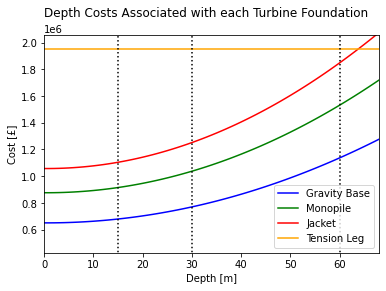

In [419]:
# Plots depth functions for each individual turbine foundation type

Depthx = range(0,math.ceil((max(data['CORR_DEPTH']))),1)
GBCost = [None] * len(Depthx)
MPCost = [None] * len(Depthx)
JCost = [None] * len(Depthx)
TLCost = [None] * len(Depthx)
Depth = 0

for i in Depthx:
    GBCost[i] = foundationDepthCost(GravityBase,Depth)
    MPCost[i] = foundationDepthCost(Monopile,Depth)
    JCost[i] = foundationDepthCost(Jacket,Depth)
    TLCost[i] = TensionLeg
    Depth += 1
    
fig, ax = plt.subplots()
fig.suptitle('Depth Costs Associated with each Turbine Foundation')

x1 = np.linspace(15,15,100)
x2 = np.linspace(30,30,100)
x3 = np.linspace(60,60,100)
y = np.linspace(0,TensionLeg+500000,100)

ax.set_xlabel('Depth [m]') # x axis label
ax.set_ylabel('Cost [£]') # y axis label
ax.set_xlim(0,math.ceil((max(data['CORR_DEPTH']-1)))) #x limits
ax.set_ylim(Monopile-500000,TensionLeg+100000) #y limits
ax.plot(Depthx,GBCost,'blue')
ax.plot(Depthx,MPCost,'green')
ax.plot(Depthx,JCost,'red')
ax.plot(Depthx,TLCost,'orange')
ax.plot(x1,y,':',color='k')
ax.plot(x2,y,':',color='k')
ax.plot(x3,y,':',color='k')
plt.legend(['Gravity Base','Monopile','Jacket','Tension Leg'])

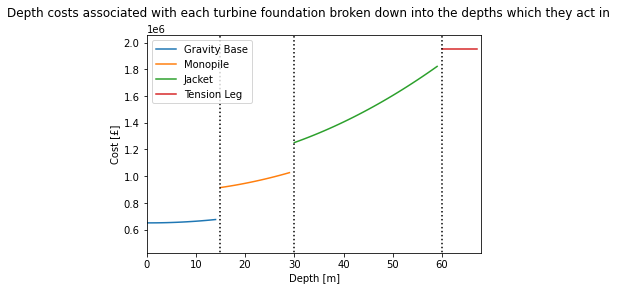

In [420]:
# Plots depth functions for each individual turbine foundation type but only considers the depths for which the foundation will act in

GBCost2 = GBCost[Depthx[0]:Depthx[15]]
MPCost2 = MPCost[Depthx[15]:Depthx[30]]
JCost2 = JCost[Depthx[30]:Depthx[60]]
TLCost2 = TLCost[Depthx[60]:max(Depthx)]

fig, ax = plt.subplots()
fig.suptitle('Depth costs associated with each turbine foundation broken down into the depths which they act in')

ax.set_xlabel('Depth [m]') # x axis label
ax.set_ylabel('Cost [£]') # y axis label
ax.set_xlim(0,math.ceil((max(data['CORR_DEPTH']-1)))) #x limits
ax.set_ylim(Monopile-500000,TensionLeg+100000) #y limits
ax.plot(Depthx[0:15],GBCost2)
ax.plot(Depthx[15:30],MPCost2)
ax.plot(Depthx[30:60],JCost2)
ax.plot(Depthx[60:max(Depthx)],TLCost2)
ax.plot(x1,y,':',color='k')
ax.plot(x2,y,':',color='k')
ax.plot(x3,y,':',color='k')
plt.legend(['Gravity Base','Monopile','Jacket','Tension Leg'])

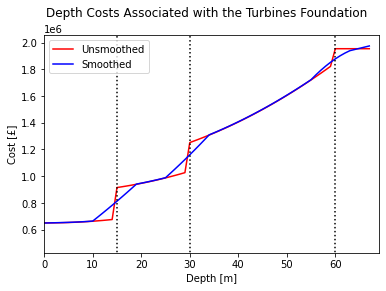

In [421]:
# Combines all the indivdual depths costs over there used depths into one plot and smooths the data

GBMPJTL = GBCost2+MPCost2+JCost2+TLCost2

fig, ax = plt.subplots()
fig.suptitle('Depth Costs Associated with the Turbines Foundation')

ax.set_xlabel('Depth [m]') # x axis label
ax.set_ylabel('Cost [£]') # y axis label
ax.set_xlim(0,math.ceil((max(data['CORR_DEPTH'])))) #x limits
ax.set_ylim(Monopile-500000,TensionLeg+100000) #y limits
ax.plot(Depthx[0:max(Depthx)],GBMPJTL,color='r')
smoothed_2dg = savgol_filter(GBMPJTL, window_length = 9, polyorder = 1)
ax.plot(Depthx[0:max(Depthx)], smoothed_2dg, color='b')
plt.legend(['Unsmoothed','Smoothed'])
ax.plot(x1,y,':',color='k')
ax.plot(x2,y,':',color='k')
ax.plot(x3,y,':',color='k')

In [422]:
def foundations(positionlist):
    
    DepthPerTurbine = [None] * (len(positionlist)-1) # none defines a null/no value. Get a null list the size of the np. turbines
    FoundationCost = [None] * (len(positionlist)-1) # Get a null list the size of the number of turbines
    FoundationCostTotal = 0 # Assigns initial value to variable
    
    for i in range(0,len(positionlist)-1): # loops for amount of turbines
        DepthPerTurbine[i] = spline.SmoothBivariateSpline.ev(smooth, positionlist[i+1,0], positionlist[i+1,1])
        
        FoundationCost[i] = np.interp(DepthPerTurbine[i],Depthx[0:max(Depthx)],smoothed_2dg)

        FoundationCostTotal += FoundationCost[i]
        
    return FoundationCostTotal

FoundationCostTotal = foundations(positionlist)

In [423]:
# Function for calculated payback time, discounted payback time, Net Present Value, and Profitability Index

def Payback(TPO,TotalCost,positionlist):
    
    nturb=np.size(positionlist,0)-1 # -1 due to the substation at positonlist[0,:]
    
    CashFlowYearly = (ElectricityCostperkWh*24*365*(TPO/1000))-(OperatingandMaintenanceCostsperAnnum*nturb) # Calculates the yaerly cash flow for the windfarm
    PayBackTime = TotalCost/CashFlowYearly # calculates payback time in years
    DiscountedPayBackTime = (np.log(1/(1-((TotalCost*DiscountRate)/CashFlowYearly))))/np.log(1+DiscountRate) #Calculates payback time but takes into account the time value of money
    
    l=0
    NPV = 0
    
    for l in range(LifeTimeTurbineOperatingTime):
        l+=1
        NPV = NPV + (CashFlowYearly)/((1+DiscountRate)**l) #NPV is a method used to determine the current value of future cash flows generated by the project
    
    NPV = NPV - TotalCost
    ProfIndex = (NPV+TotalCost)/TotalCost # Probability index >1 it's profitable <1 its not
    
    return PayBackTime,DiscountedPayBackTime,NPV,ProfIndex

In [424]:
#PLOTTING FUNCTION

def plotting_function(positionlist,indiceslist,MSTweight,data,OnshoreSubstation,ExportDistance):
    
    mindepth = depthvalues(positionlist)[1]
    maxdepth = depthvalues(positionlist)[2]
    
    nturb=np.size(positionlist,0)-1 # -1 due to the substation ar positonlist[0,:]
    links = [None] * math.ceil(nturb/maxnodespertree) # math.ceil rounds a number upwards to its nearest integer
    MSTWeightSum = 0

    fig, (ax1,ax2) = plt.subplots(2,sharex=True,figsize=(7,7))
    fig.suptitle('Plot Showing Sea Floor Topography and Turbines with Cables')
    
    #Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)
    ax1.set_ylabel('y distance [m]') # y axis label
    ax1.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
    ax1.set_ylim([min(positionlist[:,1])-100, max(positionlist[:,1])+100]) #y limits 
    
    #Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
    ax2.set_xlabel('x distance [m]') # x axis label
    ax2.set_ylabel('y distance [m]') # y axis label
    ax2.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
    ax2.set_ylim([min(positionlist[:,1])-DistanceToShore-1000, min(positionlist[:,1])-100]) #y limits
    
    for a in range(0,len(MSTweight)):
        MSTWeightSum += MSTweight[a][0]
        links[a] = MSTweight[a][1]
        for b in links[a]:
            u = positionlist[(indiceslist[a,b[0]])][0], positionlist[(indiceslist[a,b[1]])][0]
            v = positionlist[(indiceslist[a,b[0]])][1], positionlist[(indiceslist[a,b[1]])][1]
            ax1.plot(u,v, c='black')
    
    FoundationCostTotal = foundations(positionlist)
    ExportCableCost = (ExportDistance*ExportCableCostperMeter) # Export cable cost
    FixedCost = (OffshoreSubstationCostperMW+OnshoreSubstationCostperMW)*TurbineRating*nturb
    CableCost=(MSTWeightSum/1000)*IACableCostperMeter
    DepthCostAll = depthvalues(positionlist)[0]
    TurbineCostTotal =(nturb)*CostperTurbine
    MaintenanceCosts=(nturb)*MaintenanceCostperTurbine 
    LandCost = LandAreaCost(positionlist,ExportDistance)
    TotalCost=TurbineCostTotal+DepthCostAll+MaintenanceCosts+FixedCost+LandCost+CableCost+ExportCableCost+FoundationCostTotal 

    print('\033[1m'+'Maximum turbines per MST:'+'\033[0m', maximumturbinespertree)
    print('\033[1m'+'Number of turbines:'+'\033[0m', nturb)
    print()
    print('\033[1m'+'Inter-Array Cabling Costs: £'+'\033[0m', CableCost)
    print('\033[1m'+'Export Cabling Costs: £'+'\033[0m', ExportCableCost)
    print('\033[1m'+'Depth Cost: £'+'\033[0m', DepthCostAll)
    print('\033[1m'+'Foundations Cost: £'+'\033[0m', FoundationCostTotal)
    print('\033[1m'+'Turbine Cost: £'+'\033[0m', TurbineCostTotal)
    print('\033[1m'+'Land Cost: £'+'\033[0m', LandCost)
    print('\033[1m'+'Maintenance Cost: £'+'\033[0m', MaintenanceCosts)
    print('\033[1m'+'Fixed Cost:'+'\033[0m', FixedCost)
    print()
    print('\033[1m'+'Budget: £'+'\033[0m', budget)
    print('\033[1m'+'Total Cost: £'+'\033[0m', TotalCost)
        
    levels = np.linspace(mindepth-3,maxdepth+3,24) # Change to min(smooth) and max(smooth) somehow
    
    fig.subplots_adjust(left=0.1, right=0.8) #Adjusts plots to be able to fit a single color bar across both plots
    
    #Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)
    tcf = ax1.tricontourf(data['centered_easting'], data['centered_northing'], smooth(data['centered_easting'], data['centered_northing'], grid=False), levels=levels, cmap = 'viridis_r')
    cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8]) #Locates colorbar across both subplots
    cbar = plt.colorbar(tcf,cax=cb_ax) #plots colorbar with location as stated by cb_ax
    cbar.set_label('Depth (m)')    
    
    ax1.scatter(positionlist[:,0],positionlist[:,1],c='red') # Prints turbine positions in red
    ax1.scatter(positionlist[0,0],positionlist[0,1],c='blue') # offshore Substation
    ax1.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
    
    #Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
    tcf = ax2.tricontourf(data['centered_easting'], data['centered_northing'], smooth(data['centered_easting'], data['centered_northing'], grid=False), levels=levels, cmap = 'viridis_r')

    ax2.scatter(OnshoreSubstation[0],OnshoreSubstation[1],c='blue') #onshore substation
    ax2.plot(TXShoreLine,TYShoreLine,c='green',linewidth=1) #Produces line representing the shore line in green
    ax2.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
    
    fig, ax3 = plt.subplots()
    PieChartLabels = ['(Inter-Array) Cabling Costs', 'Depth Costs', 'Turbine Costs', 'Land Costs', '(Life time) Maintenance Costs', 'Fixed Costs','(Export) Cabling Costs','Foundation Costs'] # Titles for each segment of pie chart
    sizes = [CableCost,DepthCostAll,TurbineCostTotal,LandCost,MaintenanceCosts,FixedCost,ExportCableCost,FoundationCostTotal] # Figures for each segment of pie chart
    
    ax3.pie(sizes, labels=PieChartLabels, autopct='%1.1f%%') # Pie chart with brekadown of all associated costs
    ax3.axis('equal') #equal aspect ratio
    ax3.set_title('Wind Farm Costs') #Pie chart title
                                                                                                  
    return TotalCost

PRE-OPTIMISED LAYOUT INFORMATION
Maximum turbines per MST: 10
Number of turbines: 35

Inter-Array Cabling Costs: £ 3780363.3873498226
Export Cabling Costs: £ 10507878.151260504
Depth Cost: £ 5670839.477005682
Foundations Cost: £ 35499125.476335056
Turbine Cost: £ 77720207.253886
Land Cost: £ 3658785.553234949
Maintenance Cost: £ 45850000.0
Fixed Cost: 11250000.0

Budget: £ 200000000.0
Total Cost: £ 193937199.29907197
Total Power Output: 13842910.903156877 W
Theoretical Max Total Power Output: 26417525.27912108 W
Percentage power lost to wake effcts: 47.59951677193044 %
Cost per Watt: 14.009856789213647 £/W

Payback Time: 12.78467844969366 years
Discounted Payback Time: 33.30105848440848 years
NPV: £ -33231283.996281922 over a  20 year period
Profitability Index: £ 0.8286492528695554 over a  20 year period


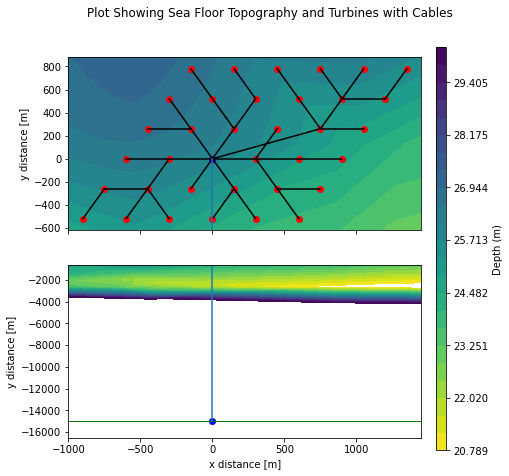

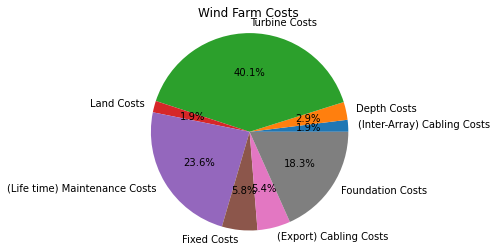

In [425]:
## PRE-OPTIMISED LAYOUT AND GAUSSIAN TESTING

# CALCULATES 
wsr=windspeedreduction(positionlist[1:,:],angles,predict_class)
powout=power(wsr,velocities) # total output power
output=np.tensordot(powout,wsp,axes=2)

## Below calculates max theoreticl power output
wsr_noWake = np.multiply(0.92477772, np.ones(wsr.shape))  ## 0.92477772 is not 1 because of the impact of the hub height
powout_noWake = power(wsr_noWake,velocities)
output_noWake=np.tensordot(powout_noWake,wsp,axes=2)
theoretical_max_power = np.sum(output_noWake)


#DISPLAYING PRE-OPTIMISED LAYOUT AND ASSOCIATED INFO

print('\033[1m'+'\033[4m'+'PRE-OPTIMISED LAYOUT INFORMATION'+'\033[0m'+'\033[0m')
MSTweight = Minimum_Spanning_Tree(distance,indiceslist)
TotalCost = plotting_function(positionlist,indiceslist,MSTweight,data,OnshoreSubstation,ExportDistance)

PayBackTime,DiscountedPayBackTime,NPV,ProfIndex = Payback((np.sum(output)),TotalCost,positionlist)

print('\033[1m'+'Total Power Output:'+'\033[0m', np.sum(output), 'W')
print('\033[1m'+'Theoretical Max Total Power Output:'+'\033[0m', theoretical_max_power, 'W')
print('\033[1m'+'Percentage power lost to wake effcts:'+'\033[0m', (1-(np.sum(output)/theoretical_max_power))*100, '%')
print('\033[1m'+'Cost per Watt:'+'\033[0m',TotalCost/np.sum(output),'£/W')
print('')
print('\033[1m'+'Payback Time:'+'\033[0m',PayBackTime,'years')
print('\033[1m'+'Discounted Payback Time:'+'\033[0m',DiscountedPayBackTime,'years')
print('\033[1m'+'NPV: £'+'\033[0m',NPV,'over a ',LifeTimeTurbineOperatingTime,'year period')
print('\033[1m'+'Profitability Index: £'+'\033[0m',ProfIndex,'over a ',LifeTimeTurbineOperatingTime,'year period')

In [426]:
#REDUCING NO. OF TURBINES PRE-OPTIMISATION

overspend = TotalCost - budget
if overspend > 0:
    nturbstoremove = math.floor(overspend/(MinCostperTurbTot))
    ### It can be safely assumed that this many turbines at minimum can be removed.
    print('Number of removed turbines:', nturbstoremove)
    for amount in range(0,nturbstoremove):
        nturb = nturb - 1
        positionlist = np.delete(positionlist, len(positionlist)-1, 0)
    indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree)
    print('new number of turbines:', nturb)

In [427]:
v=2
for amount in range(0,v):
    nturb = nturb - 1
    positionlist = np.delete(positionlist, len(positionlist)-1, 0)
indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree)

 C:\Users\adamb\anaconda3\lib\site-packages\pulp\pulp.py:1352: UserWarning:Spaces are not permitted in the name. Converted to '_'


In [428]:
#TARGET FUNCTION

# analyses the coordinates to collate the distances and angles between all of them
# calculates the minimum spanning tree length and adds the assumption of cabling costs,
# turbines costs, maintenance costs and fixed costs.

smallestindiceslist = []
smallestTotalCost = None
smallestCostPerWatt = 10000000000000.0
smallestpositionlist = []
smallestExportDistance = None

def targetfunction(coord_flat):
    
    #Global variables are used instead of res.x as res.x only holds the coordinates, not the other associated parameters,
    #inc. the optimal clustering, which will not necessarily be the same if the clustering algorithm is run again as the
    #start position is random for clustering. Additionally, res.x only provides an approximate minimization, whereas
    #storing values as global variables and finding the minimum guarantees that the minimum value found is returned.
    
    global smallestindiceslist
    global smallestTotalCost
    global smallestCostPerWatt
    global smallestpositionlist
    global smallestExportDistance

    arr2=np.reshape(coord_flat,(-1,2)) # undoes the coordinate flattening
    hull = ConvexHull(arr2)
    arr1 = np.array([np.mean(hull.points[hull.vertices,0]),np.mean(hull.points[hull.vertices,1])])
    arr1 = np.reshape(arr1,(-1,2))
    positionlist = np.concatenate((arr1,arr2),axis=0)
    #positionlist = np.reshape(coord_flat,(-1,2))#np.concatenate((arr1,arr2),axis=0) #np.reshape(coord_flat,(-1,2))
    
    nturb=np.size(positionlist,0)-1 # determines number of turbines (-1 due to the substation)
    print('nturb', nturb)
    
    OnshoreSubstation,ExportDistance = Substation_To_Shore_Connection(positionlist)

    indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree) # calls clustering function
    distance,angle,distance_global,angle_global = geom_analysis(positionlist,indiceslist) # calls pre-MST function
    
    MSTweight=Minimum_Spanning_Tree(distance,indiceslist) # Calls MST function
    MSTWeightSum=0
    
    for a in range(0,math.ceil(nturb/maxnodespertree)): 
        MSTWeightSum += MSTweight[a][0] 
#     wsr=windspeedreduction(distance_global,angle_global,angles,model) ## old WSR function
    wsr=windspeedreduction(positionlist[1:,:],angles,predict_class) ## new WSR function ## the "turbine" at origin is substantion and hence removed
    powout=power(wsr,velocities) # total output power
    output=np.tensordot(powout,wsp,axes=2) # reduced power output due to wake effects
    
    FoundationCostTotal = foundations(positionlist)
    ExportCableCost = (ExportDistance*ExportCableCostperMeter) # Export cable cost
    FixedCost = (OffshoreSubstationCostperMW+OnshoreSubstationCostperMW)*TurbineRating*nturb
    CableCost= (MSTWeightSum/1000)*IACableCostperMeter
    DepthCostAll = depthvalues(positionlist)[0]
    TurbineCostTotal= (nturb)*CostperTurbine
    MaintenanceCosts= (nturb)*MaintenanceCostperTurbine
    LandCost = LandAreaCost(positionlist,ExportDistance)
    TotalCost= TurbineCostTotal+DepthCostAll+MaintenanceCosts+FixedCost+LandCost+CableCost+ExportCableCost+FoundationCostTotal

    print('Total power output in Watts', np.sum(output),'Total Cost in £', TotalCost, '£/W', (TotalCost/(np.sum(output))))###

    CostperWatt = TotalCost/(np.sum(output))
    
    if CostperWatt < smallestCostPerWatt:
        smallestCostPerWatt = CostperWatt
        smallestindiceslist = indiceslist
        smallestTotalCost = TotalCost
        smallestpositionlist = positionlist
        smallestExportDistance = ExportDistance

    print('smallest cost per watt',smallestCostPerWatt)
    
    return CostperWatt

In [429]:
angles

array([  0.,  30.,  60.,  90., 120., 150., 180., 210., 240., 270., 300.,
       330.])

In [430]:
# OPTIMIZATION

#xright = 0
#xleft = 0
#yup = 0
#ydown = 0
#for xright in range(0,nturb+1):
 #   if positionlist[xright,0]>0:
  #      positionlist[xright,0] = positionlist[xright,0] + 250
#for xleft in range(0,nturb+1):
 #   if positionlist[xleft,0]<0:
  #      positionlist[xleft,0] = positionlist[xleft,0] - 250
#for yup in range(0,nturb+1):
 #   if positionlist[yup,1]>0:
  #      positionlist[yup,1] = positionlist[yup,1] + 250
#for ydown in range(0,nturb+1):
 #   if positionlist[ydown,1]<0:
  #      positionlist[ydown,1] = positionlist[ydown,1] - 250
        
        
t1_start = perf_counter() # timer starts

dvel=1.5
dang=30
velocities=np.arange(Vc,Vf,dvel)
angles=np.arange(0,360,dang)        
wsp=windspeedprobability(angles,velocities,dang,dvel) # tells probability of getting wind from a certain direction with a certain velocity.

while True:  
    
    iteration_time_start = perf_counter()
    
    #flat_coords=positionlist.flatten() # turns 2D coords into single list of data without any more structure.
    flat_coords=positionlist[1:,:].flatten() # turns 2D coords into single list of data without any more structure.
        
    # b = (Lower bound, Upper bound)
    b2 = ((min(positionlist[:,0]))-1000,(max(positionlist[:,0]))+1000) #bounds for x coordinates
    #b3 = ((OnshoreSubstation[1]+((TooCloseShore-2500))),(max(positionlist[:,1]))+1000) #bounds for y coordinates of turbines
    b3 = (((min(positionlist[:,1]))-1000),(max(positionlist[:,1]))+1000) #bounds for y coordinates of turbines
    bnd = (b2,b3) #bounds for x,y coordinates of each turbine 
    bnd1 = (bnd*(nturb)) #repeats bnd for the amount of turbines 
    bnds = bnd1 #Combines all bounds into a list for use in the optimization function
    
    #res = minimize(targetfunction, flat_coords, method='L-BFGS-B', jac=False, bounds=bnds, options={'disp': 2, 'eps': 50, 'ftol': 1e-17, 'gtol': 1e-17})
    res = minimize(targetfunction, flat_coords, method='L-BFGS-B', jac=False, options={'disp': 2, 'eps': 50})#, 'ftol': 1e-17, 'gtol': 1e-17})

    #res = minimize(targetfunction, flat_coords, method='Nelder-Mead', jac=False, bounds=bnds, options={'disp': 2, 'xatol': 1e-3, 'fatol': 1e-3})#, 'ftol': 1e-17, 'gtol': 1e-17})
    #res = minimize(targetfunction, flat_coords, method='TNC', jac=False, bounds=bnds, options={'disp': 2, 'eps':50})#, 'ftol': 1e-17, 'gtol': 1e-17})
    
    iteration_time_end = perf_counter()
    print(iteration_time_end-iteration_time_start)
    
    if smallestTotalCost<=budget: #if under budget
        if not res.success:
            print(res.status, res.message) 
        else:
            break # Stops optimization when minimization is under budget after an iteration of 'minimize' 
    else: # over budget then removes a turbine and resets approrate varaibles 
        nturb = nturb - 1 
        smallestindiceslist = []
        smallestTotalCost = None
        smallestCostPerWatt = 10000000000000.0
        smallestpositionlist = []
        smallestExportDistance = None
        
        wsr=windspeedreduction(positionlist[1:,:],angles,predict_class) ## new WSR function ## the "turbine" at origin is substantion and hence removed
        powout=power(wsr,velocities) # total output power
        outputs=np.tensordot(powout,wsp,axes=2)
        LowestPower = min(outputs)
        LowestPowerIndex = np.argmin(outputs)
        LowestPowerTurbine = positionlist[LowestPowerIndex+1,:]
        positionlist = np.delete(positionlist, LowestPowerIndex+1, 0) 

        # CANNOT USE CALLBACK as this only returns targetfunction output and not the other variables that are needed too.
          
t1_stop = perf_counter() # timer ends
totaltime = t1_stop - t1_start # total run time in seconds
print('Total function time:', totaltime)

nturb 33
Total power output in Watts 13381399.944564622 Total Cost in £ 183404115.22533402 £/W 13.705898933230133
smallest cost per watt 13.705898933230133
nturb 33
Total power output in Watts 13418446.927822512 Total Cost in £ 183381573.60292736 £/W 13.666378425858985
smallest cost per watt 13.666378425858985
nturb 33
Total power output in Watts 13432096.764026461 Total Cost in £ 183382939.56687614 £/W 13.652592204219985
smallest cost per watt 13.652592204219985
nturb 33
Total power output in Watts 13449791.507966705 Total Cost in £ 183378518.4653485 £/W 13.634301941166006
smallest cost per watt 13.634301941166006
nturb 33
Total power output in Watts 13445518.865420228 Total Cost in £ 183340484.69722497 £/W 13.635805842253365
smallest cost per watt 13.634301941166006
nturb 33
Total power output in Watts 13439690.49274517 Total Cost in £ 183379933.87574774 £/W 13.644654538342039
smallest cost per watt 13.634301941166006
nturb 33
Total power output in Watts 13425633.798946714 Total Cost

Total power output in Watts 13448540.047992652 Total Cost in £ 183436662.03679103 £/W 13.639894098703378
smallest cost per watt 13.605321710043958
nturb 33
Total power output in Watts 13405182.091818385 Total Cost in £ 183368183.69686726 £/W 13.678902863153406
smallest cost per watt 13.605321710043958
nturb 33
Total power output in Watts 13452564.379284017 Total Cost in £ 183462265.1284417 £/W 13.637716940493547
smallest cost per watt 13.605321710043958
nturb 33
Total power output in Watts 13417405.975131597 Total Cost in £ 183368273.61700627 £/W 13.666447445718568
smallest cost per watt 13.605321710043958
nturb 33
Total power output in Watts 13444234.828509407 Total Cost in £ 183494393.36495423 £/W 13.648556106431732
smallest cost per watt 13.605321710043958
nturb 33
Total power output in Watts 13443204.862009076 Total Cost in £ 183381757.8706494 £/W 13.641223186956859
smallest cost per watt 13.605321710043958
nturb 33
Total power output in Watts 13395035.409537518 Total Cost in £ 183

Total power output in Watts 13404604.707846723 Total Cost in £ 183271655.4051311 £/W 13.672290932820154
smallest cost per watt 13.605321710043958
nturb 33
Total power output in Watts 13421822.031063447 Total Cost in £ 183300472.88366172 £/W 13.65689937323199
smallest cost per watt 13.605321710043958
nturb 33
Total power output in Watts 13444991.265751744 Total Cost in £ 183362704.9539693 £/W 13.637993608894845
smallest cost per watt 13.605321710043958
nturb 33
Total power output in Watts 13442196.213186093 Total Cost in £ 183357563.19226137 £/W 13.640446864806004
smallest cost per watt 13.605321710043958
nturb 33
Total power output in Watts 13464139.964233287 Total Cost in £ 183310552.62797162 £/W 13.614724231545836
smallest cost per watt 13.605321710043958
nturb 33
Total power output in Watts 13459967.940076925 Total Cost in £ 183383046.13591057 £/W 13.624330084018203
smallest cost per watt 13.605321710043958
nturb 33
Total power output in Watts 13463124.318328882 Total Cost in £ 1833

Total power output in Watts 13430951.31686242 Total Cost in £ 183303016.2529689 £/W 13.647805872308828
smallest cost per watt 13.605321710043958
nturb 33
Total power output in Watts 13452540.552667713 Total Cost in £ 183339270.50614017 £/W 13.62859824048499
smallest cost per watt 13.605321710043958
nturb 33
Total power output in Watts 13421797.241938423 Total Cost in £ 183328397.93772346 £/W 13.659005171445022
smallest cost per watt 13.605321710043958
nturb 33
Total power output in Watts 13467574.969393082 Total Cost in £ 183345526.43100554 £/W 13.613848584298472
smallest cost per watt 13.605321710043958
nturb 33
Total power output in Watts 13417553.904106071 Total Cost in £ 183347754.8662478 £/W 13.664767525930289
smallest cost per watt 13.605321710043958
nturb 33
Total power output in Watts 13459982.049029665 Total Cost in £ 183368266.6739505 £/W 13.623217772951605
smallest cost per watt 13.605321710043958
nturb 33
Total power output in Watts 13397528.674963078 Total Cost in £ 183175

Total power output in Watts 13451352.64501859 Total Cost in £ 183382977.27707684 £/W 13.633051048214742
smallest cost per watt 13.593247748252665
nturb 33
Total power output in Watts 13455970.988226857 Total Cost in £ 183384815.86610043 £/W 13.628508565197622
smallest cost per watt 13.593247748252665
nturb 33
Total power output in Watts 13477506.349934524 Total Cost in £ 183381519.65203077 £/W 13.606487349413985
smallest cost per watt 13.593247748252665
nturb 33
Total power output in Watts 13459576.545169884 Total Cost in £ 183460449.1855646 £/W 13.630477048804435
smallest cost per watt 13.593247748252665
nturb 33
Total power output in Watts 13489674.606301052 Total Cost in £ 183370627.62904957 £/W 13.593406288940194
smallest cost per watt 13.593247748252665
nturb 33
Total power output in Watts 13481479.919589635 Total Cost in £ 183486712.7800461 £/W 13.610279722586368
smallest cost per watt 13.593247748252665
nturb 33
Total power output in Watts 13465920.934402721 Total Cost in £ 1833

Total power output in Watts 13483419.1360191 Total Cost in £ 183457406.9956352 £/W 13.606148792449385
smallest cost per watt 13.578373115055042
nturb 33
Total power output in Watts 13425016.475213876 Total Cost in £ 183364620.55085766 £/W 13.658427972092039
smallest cost per watt 13.578373115055042
nturb 33
Total power output in Watts 13470173.373598788 Total Cost in £ 183433866.20437613 £/W 13.61778064148024
smallest cost per watt 13.578373115055042
nturb 33
Total power output in Watts 13809759.520180082 Total Cost in £ 183357727.39585456 £/W 13.277401907536152
smallest cost per watt 13.277401907536152
nturb 33
Total power output in Watts 13811528.840626052 Total Cost in £ 183435096.3038509 £/W 13.281302773975607
smallest cost per watt 13.277401907536152
nturb 33
Total power output in Watts 13847201.66094099 Total Cost in £ 183379295.07455477 £/W 13.243058024627135
smallest cost per watt 13.243058024627135
nturb 33
Total power output in Watts 13938398.45654484 Total Cost in £ 18356493

Total power output in Watts 13818119.722062893 Total Cost in £ 183457890.46119162 £/W 13.276617524761422
smallest cost per watt 13.15250044308068
nturb 33
Total power output in Watts 13815822.933972836 Total Cost in £ 183432527.36872235 £/W 13.276988873219082
smallest cost per watt 13.15250044308068
nturb 33
Total power output in Watts 13838901.174614344 Total Cost in £ 183456516.64846915 £/W 13.256581164478302
smallest cost per watt 13.15250044308068
nturb 33
Total power output in Watts 13829186.845380675 Total Cost in £ 183458329.0202423 £/W 13.266024320260188
smallest cost per watt 13.15250044308068
nturb 33
Total power output in Watts 13857368.118527498 Total Cost in £ 183503440.03402036 £/W 13.242301024584435
smallest cost per watt 13.15250044308068
nturb 33
Total power output in Watts 13775187.648291212 Total Cost in £ 183437665.53324106 £/W 13.31652752882798
smallest cost per watt 13.15250044308068
nturb 33
Total power output in Watts 13852129.136904769 Total Cost in £ 183489934

Total power output in Watts 15604829.205110438 Total Cost in £ 183594429.44467297 £/W 11.76523158513952
smallest cost per watt 11.657316006434824
nturb 33
Total power output in Watts 15670778.567445522 Total Cost in £ 183802191.19805685 £/W 11.728976349642739
smallest cost per watt 11.657316006434824
nturb 33
Total power output in Watts 15617712.67381731 Total Cost in £ 183659398.87628406 £/W 11.759686114867785
smallest cost per watt 11.657316006434824
nturb 33
Total power output in Watts 15627417.350388246 Total Cost in £ 183834975.0175312 £/W 11.763618446714359
smallest cost per watt 11.657316006434824
nturb 33
Total power output in Watts 15576688.904181363 Total Cost in £ 183711817.9180152 £/W 11.794022404125958
smallest cost per watt 11.657316006434824
nturb 33
Total power output in Watts 15576948.595040029 Total Cost in £ 183697775.96017295 £/W 11.792924322717834
smallest cost per watt 11.657316006434824
nturb 33
Total power output in Watts 15699811.143560963 Total Cost in £ 18367

Total power output in Watts 16351167.942530448 Total Cost in £ 184401192.1267899 £/W 11.277554776203505
smallest cost per watt 11.168484320402735
nturb 33
Total power output in Watts 16349194.545677755 Total Cost in £ 184309962.76492792 £/W 11.27333595853834
smallest cost per watt 11.168484320402735
nturb 33
Total power output in Watts 16335639.909382682 Total Cost in £ 184353487.00116333 £/W 11.285354477927518
smallest cost per watt 11.168484320402735
nturb 33
Total power output in Watts 16392739.626152204 Total Cost in £ 184412259.87841365 £/W 11.24963026828115
smallest cost per watt 11.168484320402735
nturb 33
Total power output in Watts 16454149.202676868 Total Cost in £ 184298077.3916027 £/W 11.200705373549177
smallest cost per watt 11.168484320402735
nturb 33
Total power output in Watts 16361203.00491991 Total Cost in £ 184415284.64362177 £/W 11.271499081587521
smallest cost per watt 11.168484320402735
nturb 33
Total power output in Watts 16413228.650822345 Total Cost in £ 184298

Total power output in Watts 17259878.62358617 Total Cost in £ 184742932.91625008 £/W 10.703605566715458
smallest cost per watt 10.686505076822671
nturb 33
Total power output in Watts 17259189.76058248 Total Cost in £ 184813699.03753084 £/W 10.70813297734398
smallest cost per watt 10.686505076822671
nturb 33
Total power output in Watts 17267731.531802483 Total Cost in £ 184785996.68037388 £/W 10.70123173620392
smallest cost per watt 10.686505076822671
nturb 33
Total power output in Watts 17265762.50020507 Total Cost in £ 184711261.74680984 £/W 10.698123627300907
smallest cost per watt 10.686505076822671
nturb 33
Total power output in Watts 17193713.381336283 Total Cost in £ 184711333.76819858 £/W 10.742957595693209
smallest cost per watt 10.686505076822671
nturb 33
Total power output in Watts 17176733.05040241 Total Cost in £ 184788314.0887628 £/W 10.758059378726482
smallest cost per watt 10.686505076822671
nturb 33
Total power output in Watts 17251572.097229525 Total Cost in £ 18477963

Total power output in Watts 17337504.50498969 Total Cost in £ 184804887.95628473 £/W 10.659255367639462
smallest cost per watt 10.580094173504882
nturb 33
Total power output in Watts 17312988.12814468 Total Cost in £ 184789439.68749756 £/W 10.673457309607722
smallest cost per watt 10.580094173504882
nturb 33
Total power output in Watts 17302435.500330232 Total Cost in £ 184834807.48999795 £/W 10.682589019705938
smallest cost per watt 10.580094173504882
nturb 33
Total power output in Watts 17225369.680938866 Total Cost in £ 184753733.24924773 £/W 10.725675946083832
smallest cost per watt 10.580094173504882
nturb 33
Total power output in Watts 17309379.02263204 Total Cost in £ 184860288.6033893 £/W 10.679775881138438
smallest cost per watt 10.580094173504882
nturb 33
Total power output in Watts 17036729.172357395 Total Cost in £ 185618650.98456067 £/W 10.895204654995192
smallest cost per watt 10.580094173504882
nturb 33
Total power output in Watts 17044047.672127135 Total Cost in £ 18577

Total power output in Watts 17020233.669478614 Total Cost in £ 185831751.70777225 £/W 10.918284397059333
smallest cost per watt 10.580094173504882
nturb 33
Total power output in Watts 17040137.54460203 Total Cost in £ 185841438.92231157 £/W 10.906099697603814
smallest cost per watt 10.580094173504882
nturb 33
Total power output in Watts 17062141.920794595 Total Cost in £ 185689069.01003605 £/W 10.883104235800918
smallest cost per watt 10.580094173504882
nturb 33
Total power output in Watts 16938618.965112254 Total Cost in £ 185743774.63174173 £/W 10.965697676670702
smallest cost per watt 10.580094173504882
nturb 33
Total power output in Watts 17104311.516467195 Total Cost in £ 185908152.05771634 £/W 10.869081276889343
smallest cost per watt 10.580094173504882
nturb 33
Total power output in Watts 16984473.898658276 Total Cost in £ 185675684.48011005 £/W 10.932083359660488
smallest cost per watt 10.580094173504882
nturb 33
Total power output in Watts 16975351.48838548 Total Cost in £ 185

Total power output in Watts 17593250.758742828 Total Cost in £ 184998265.84151196 £/W 10.515297506890734
smallest cost per watt 10.478369565875138
nturb 33
Total power output in Watts 17560906.928793352 Total Cost in £ 184790237.64924815 £/W 10.522818576429042
smallest cost per watt 10.478369565875138
nturb 33
Total power output in Watts 17579532.811310593 Total Cost in £ 184775924.27211082 £/W 10.510855223252964
smallest cost per watt 10.478369565875138
nturb 33
Total power output in Watts 17553848.18332243 Total Cost in £ 184715610.88220394 £/W 10.522798702206998
smallest cost per watt 10.478369565875138
nturb 33
Total power output in Watts 17566377.452067018 Total Cost in £ 184760184.2433102 £/W 10.517830710825907
smallest cost per watt 10.478369565875138
nturb 33
Total power output in Watts 17554856.472786963 Total Cost in £ 184569591.29896232 £/W 10.513876407082954
smallest cost per watt 10.478369565875138
nturb 33
Total power output in Watts 17551320.26408054 Total Cost in £ 1847

Total power output in Watts 17385941.824714687 Total Cost in £ 185221664.62071753 £/W 10.653530679449235
smallest cost per watt 10.46671133862054
nturb 33
Total power output in Watts 17335455.303918876 Total Cost in £ 185377894.22672734 £/W 10.693569391559077
smallest cost per watt 10.46671133862054
nturb 33
Total power output in Watts 17347907.046858463 Total Cost in £ 185196172.111009 £/W 10.675418747101611
smallest cost per watt 10.46671133862054
nturb 33
Total power output in Watts 17506859.91711594 Total Cost in £ 185200168.17183173 £/W 10.5787199445611
smallest cost per watt 10.46671133862054
nturb 33
Total power output in Watts 17391322.967653897 Total Cost in £ 185211261.4373021 £/W 10.64963613071739
smallest cost per watt 10.46671133862054
nturb 33
Total power output in Watts 17382505.932524726 Total Cost in £ 185193894.23016518 £/W 10.65403889111555
smallest cost per watt 10.46671133862054
nturb 33
Total power output in Watts 17465731.966305822 Total Cost in £ 185228790.95734

Total power output in Watts 17626275.73525358 Total Cost in £ 184834919.06056347 £/W 10.486328583348033
smallest cost per watt 10.45824590134142
nturb 33
Total power output in Watts 17617049.399515618 Total Cost in £ 184719753.42515126 £/W 10.485283275088628
smallest cost per watt 10.45824590134142
nturb 33
Total power output in Watts 17566095.77503494 Total Cost in £ 184733884.99931207 £/W 10.51650220772775
smallest cost per watt 10.45824590134142
nturb 33
Total power output in Watts 17698099.06238651 Total Cost in £ 184872632.89500207 £/W 10.445903384500145
smallest cost per watt 10.445903384500145
nturb 33
Total power output in Watts 17622112.36383173 Total Cost in £ 184799138.95071754 £/W 10.486775656362633
smallest cost per watt 10.445903384500145
nturb 33
Total power output in Watts 17548207.75295857 Total Cost in £ 184778847.46846762 £/W 10.529784583688583
smallest cost per watt 10.445903384500145
nturb 33
Total power output in Watts 17575982.404044 Total Cost in £ 184839162.827

Total power output in Watts 17668988.325439297 Total Cost in £ 184833230.38664696 £/W 10.460883610440188
smallest cost per watt 10.435938837622082
nturb 33
Total power output in Watts 17646988.27954227 Total Cost in £ 184865920.3955707 £/W 10.475777365924888
smallest cost per watt 10.435938837622082
nturb 33
Total power output in Watts 17685585.986025788 Total Cost in £ 184871037.83965334 £/W 10.45320398123809
smallest cost per watt 10.435938837622082
nturb 33
Total power output in Watts 17693572.59222802 Total Cost in £ 184762304.32779327 £/W 10.442340198098314
smallest cost per watt 10.435938837622082
nturb 33
Total power output in Watts 17647650.46615397 Total Cost in £ 184962760.88789576 £/W 10.480871730921441
smallest cost per watt 10.435938837622082
nturb 33
Total power output in Watts 17612075.660073556 Total Cost in £ 184811645.12130496 £/W 10.49346191149244
smallest cost per watt 10.435938837622082
nturb 33
Total power output in Watts 17687627.171788994 Total Cost in £ 1849748

Total power output in Watts 17668421.175207984 Total Cost in £ 184941347.92918384 £/W 10.467338654383578
smallest cost per watt 10.363625829744961
nturb 33
Total power output in Watts 17760488.39831026 Total Cost in £ 185086057.6935994 £/W 10.421225674807939
smallest cost per watt 10.363625829744961
nturb 33
Total power output in Watts 17689929.05153131 Total Cost in £ 185106783.01543772 £/W 10.463964127624024
smallest cost per watt 10.363625829744961
nturb 33
Total power output in Watts 17774796.841812003 Total Cost in £ 185155613.9688608 £/W 10.416749941879258
smallest cost per watt 10.363625829744961
nturb 33
Total power output in Watts 17692871.228273634 Total Cost in £ 184888032.69692615 £/W 10.449860303141223
smallest cost per watt 10.363625829744961
nturb 33
Total power output in Watts 17748837.174645904 Total Cost in £ 185070688.4000201 £/W 10.427200755686256
smallest cost per watt 10.363625829744961
nturb 33
Total power output in Watts 17769938.01336604 Total Cost in £ 1849833

Total power output in Watts 17758259.790010735 Total Cost in £ 185522323.36281085 £/W 10.447100422935005
smallest cost per watt 10.363625829744961
nturb 33
Total power output in Watts 17763331.500180583 Total Cost in £ 185469741.84696737 £/W 10.441157495995718
smallest cost per watt 10.363625829744961
nturb 33
Total power output in Watts 17839862.75237998 Total Cost in £ 185607454.93563694 £/W 10.40408536275737
smallest cost per watt 10.363625829744961
nturb 33
Total power output in Watts 17629521.72173065 Total Cost in £ 185474298.21991384 £/W 10.520665344613006
smallest cost per watt 10.363625829744961
nturb 33
Total power output in Watts 17753505.96990783 Total Cost in £ 185453217.31754112 £/W 10.446005292243914
smallest cost per watt 10.363625829744961
nturb 33
Total power output in Watts 17690563.626339614 Total Cost in £ 185652713.47796735 £/W 10.494448758068263
smallest cost per watt 10.363625829744961
nturb 33
Total power output in Watts 17725801.34576062 Total Cost in £ 185502

Total power output in Watts 17863427.87185904 Total Cost in £ 185038485.8497138 £/W 10.358509418072675
smallest cost per watt 10.321116731911426
nturb 33
Total power output in Watts 17875681.73621397 Total Cost in £ 185130695.4336866 £/W 10.356566992274997
smallest cost per watt 10.321116731911426
nturb 33
Total power output in Watts 17906252.394357283 Total Cost in £ 185254971.92233187 £/W 10.345826018888824
smallest cost per watt 10.321116731911426
nturb 33
Total power output in Watts 17853105.429986574 Total Cost in £ 185383077.9928022 £/W 10.383800102441988
smallest cost per watt 10.321116731911426
nturb 33
Total power output in Watts 17861027.108862944 Total Cost in £ 185177404.97930396 £/W 10.367679520928323
smallest cost per watt 10.321116731911426
nturb 33
Total power output in Watts 17954766.17800209 Total Cost in £ 185138313.23053855 £/W 10.311374227605773
smallest cost per watt 10.311374227605773
nturb 33
Total power output in Watts 17930132.562721062 Total Cost in £ 1852036

Total power output in Watts 17529559.123823185 Total Cost in £ 185954802.36835945 £/W 10.608070691044444
smallest cost per watt 10.311374227605773
nturb 33
Total power output in Watts 17519480.970735114 Total Cost in £ 185794946.98769286 £/W 10.6050485912253
smallest cost per watt 10.311374227605773
nturb 33
Total power output in Watts 17549513.357446138 Total Cost in £ 185805236.3363811 £/W 10.587486533211774
smallest cost per watt 10.311374227605773
nturb 33
Total power output in Watts 17522762.221669003 Total Cost in £ 185797061.5848485 £/W 10.603183404217406
smallest cost per watt 10.311374227605773
nturb 33
Total power output in Watts 17504285.2290245 Total Cost in £ 185953626.30382404 £/W 10.623320168223007
smallest cost per watt 10.311374227605773
nturb 33
Total power output in Watts 17577678.527997345 Total Cost in £ 185924201.9397696 £/W 10.577289921626088
smallest cost per watt 10.311374227605773
nturb 33
Total power output in Watts 17618764.650690675 Total Cost in £ 18586011

Total power output in Watts 17572535.864245996 Total Cost in £ 185775366.48493406 £/W 10.57191562561681
smallest cost per watt 10.311374227605773
nturb 33
Total power output in Watts 17578798.71354773 Total Cost in £ 185808016.77863002 £/W 10.570006506498673
smallest cost per watt 10.311374227605773
nturb 33
Total power output in Watts 17537909.121031195 Total Cost in £ 185820769.7231156 £/W 10.595377615469689
smallest cost per watt 10.311374227605773
nturb 33
Total power output in Watts 17574209.768513765 Total Cost in £ 185894347.70972013 £/W 10.57767889187094
smallest cost per watt 10.311374227605773
nturb 33
Total power output in Watts 17494929.616586555 Total Cost in £ 185986631.76216638 £/W 10.630887682213741
smallest cost per watt 10.311374227605773
nturb 33
Total power output in Watts 17423832.444959372 Total Cost in £ 185980370.64026886 £/W 10.673907203123504
smallest cost per watt 10.311374227605773
nturb 33
Total power output in Watts 17541887.092159912 Total Cost in £ 18580

Total power output in Watts 17804145.920267012 Total Cost in £ 185298336.02633664 £/W 10.407594773496312
smallest cost per watt 10.311374227605773
nturb 33
Total power output in Watts 17796596.838836387 Total Cost in £ 185384133.6084856 £/W 10.416830548407635
smallest cost per watt 10.311374227605773
nturb 33
Total power output in Watts 17858488.494028453 Total Cost in £ 185332527.56708297 £/W 10.37783951475259
smallest cost per watt 10.311374227605773
nturb 33
Total power output in Watts 17877510.524080385 Total Cost in £ 185409594.3132494 £/W 10.371108106103987
smallest cost per watt 10.311374227605773
nturb 33
Total power output in Watts 17889063.789735638 Total Cost in £ 185619218.7399725 £/W 10.376128170915061
smallest cost per watt 10.311374227605773
nturb 33
Total power output in Watts 17821580.077979993 Total Cost in £ 185310568.66690743 £/W 10.398099823700463
smallest cost per watt 10.311374227605773
nturb 33
Total power output in Watts 17873836.99961289 Total Cost in £ 185439

Total power output in Watts 17820114.57305087 Total Cost in £ 185146121.39517355 £/W 10.389726768377104
smallest cost per watt 10.300070293734793
nturb 33
Total power output in Watts 17812247.854531333 Total Cost in £ 185176418.95695457 £/W 10.396016295598915
smallest cost per watt 10.300070293734793
nturb 33
Total power output in Watts 17922949.383266896 Total Cost in £ 185185987.22448853 £/W 10.332338906083205
smallest cost per watt 10.300070293734793
nturb 33
Total power output in Watts 17956414.953258693 Total Cost in £ 185360686.33219242 £/W 10.322811475157716
smallest cost per watt 10.300070293734793
nturb 33
Total power output in Watts 17874685.584213074 Total Cost in £ 185044421.61486113 £/W 10.352317569059363
smallest cost per watt 10.300070293734793
nturb 33
Total power output in Watts 17938836.24098571 Total Cost in £ 185248901.22954357 £/W 10.326695597248198
smallest cost per watt 10.300070293734793
nturb 33
Total power output in Watts 17766165.762542963 Total Cost in £ 185

Total power output in Watts 17909958.588442657 Total Cost in £ 185248164.34610534 £/W 10.343305007173297
smallest cost per watt 10.300070293734793
nturb 33
Total power output in Watts 17877021.160146188 Total Cost in £ 185112552.3387208 £/W 10.35477614980946
smallest cost per watt 10.300070293734793
nturb 33
Total power output in Watts 17880665.91622395 Total Cost in £ 185146138.0485221 £/W 10.354543780191682
smallest cost per watt 10.300070293734793
nturb 33
Total power output in Watts 17871717.196787108 Total Cost in £ 185240873.6107143 £/W 10.365029368527384
smallest cost per watt 10.300070293734793
nturb 33
Total power output in Watts 17895301.32395988 Total Cost in £ 185195283.04243538 £/W 10.348821720843496
smallest cost per watt 10.300070293734793
nturb 33
Total power output in Watts 17909776.06691646 Total Cost in £ 185224690.65554035 £/W 10.34209975398261
smallest cost per watt 10.300070293734793
nturb 33
Total power output in Watts 17838826.88824328 Total Cost in £ 185421801.

Total power output in Watts 17833783.085540455 Total Cost in £ 185118166.58114022 £/W 10.38019615317813
smallest cost per watt 10.300070293734793
nturb 33
Total power output in Watts 17975099.623962913 Total Cost in £ 185179910.89485243 £/W 10.302024176154546
smallest cost per watt 10.300070293734793
nturb 33
Total power output in Watts 17902472.22287144 Total Cost in £ 185098392.37951276 £/W 10.339264324791907
smallest cost per watt 10.300070293734793
nturb 33
Total power output in Watts 17920177.794113714 Total Cost in £ 185030537.59319508 £/W 10.32526237847777
smallest cost per watt 10.300070293734793
nturb 33
Total power output in Watts 17899393.817400083 Total Cost in £ 185080589.58445615 £/W 10.340047907350831
smallest cost per watt 10.300070293734793
nturb 33
Total power output in Watts 17769962.129823796 Total Cost in £ 185175032.15190402 £/W 10.420676802744552
smallest cost per watt 10.300070293734793
nturb 33
Total power output in Watts 17819815.194080558 Total Cost in £ 1854

Total power output in Watts 17789482.680411298 Total Cost in £ 185173822.49513328 £/W 10.409174107071449
smallest cost per watt 10.300070293734793
nturb 33
Total power output in Watts 17913073.43486773 Total Cost in £ 185166084.95111772 £/W 10.33692434882183
smallest cost per watt 10.300070293734793
nturb 33
Total power output in Watts 17908447.348647606 Total Cost in £ 185084125.68960187 £/W 10.33501799940121
smallest cost per watt 10.300070293734793
nturb 33
Total power output in Watts 17888810.31774593 Total Cost in £ 185071624.5001368 £/W 10.345664200852045
smallest cost per watt 10.300070293734793
nturb 33
Total power output in Watts 17888549.135424007 Total Cost in £ 185103061.9277347 £/W 10.347572658152707
smallest cost per watt 10.300070293734793
nturb 33
Total power output in Watts 17879947.65450778 Total Cost in £ 185248255.6820138 £/W 10.36067103000216
smallest cost per watt 10.300070293734793
nturb 33
Total power output in Watts 17871371.82232709 Total Cost in £ 185159111.3

Total power output in Watts 17876548.825789053 Total Cost in £ 185250075.2305866 £/W 10.36274266559445
smallest cost per watt 10.298385983156733
nturb 33
Total power output in Watts 17859859.41099903 Total Cost in £ 185042807.80834478 £/W 10.360821076474197
smallest cost per watt 10.298385983156733
nturb 33
Total power output in Watts 17881368.41711463 Total Cost in £ 185121510.94535077 £/W 10.352759734437724
smallest cost per watt 10.298385983156733
nturb 33
Total power output in Watts 17924371.957888726 Total Cost in £ 185174970.47225183 £/W 10.330904251892305
smallest cost per watt 10.298385983156733
nturb 33
Total power output in Watts 17871339.568633493 Total Cost in £ 185116318.09357768 £/W 10.358278817469325
smallest cost per watt 10.298385983156733
nturb 33
Total power output in Watts 17927991.400192797 Total Cost in £ 185088249.5187348 £/W 10.323981386824203
smallest cost per watt 10.298385983156733
nturb 33
Total power output in Watts 17936491.6665498 Total Cost in £ 18516983

Total power output in Watts 17943278.707663212 Total Cost in £ 185142456.71253443 £/W 10.318206595847158
smallest cost per watt 10.298169564926482
nturb 33
Total power output in Watts 17798922.169030663 Total Cost in £ 185060741.72312823 £/W 10.39730046379582
smallest cost per watt 10.298169564926482
nturb 33
Total power output in Watts 17882366.439374413 Total Cost in £ 185231514.1056896 £/W 10.358333430514895
smallest cost per watt 10.298169564926482
nturb 33
Total power output in Watts 17820114.57305087 Total Cost in £ 185243606.84409142 £/W 10.395197297116873
smallest cost per watt 10.298169564926482
nturb 33
Total power output in Watts 17812247.854531333 Total Cost in £ 185394214.5829167 £/W 10.408243591543865
smallest cost per watt 10.298169564926482
nturb 33
Total power output in Watts 17922949.383266896 Total Cost in £ 185166578.0268499 £/W 10.331255981770717
smallest cost per watt 10.298169564926482
nturb 33
Total power output in Watts 17956414.953258693 Total Cost in £ 185260

Total power output in Watts 18087216.607624855 Total Cost in £ 185474373.057194 £/W 10.254445284798841
smallest cost per watt 10.164227096945217
nturb 33
Total power output in Watts 18072982.371402457 Total Cost in £ 185378604.5082327 £/W 10.257222670762081
smallest cost per watt 10.164227096945217
nturb 33
Total power output in Watts 18087181.71714769 Total Cost in £ 185328867.08710626 £/W 10.24642036472735
smallest cost per watt 10.164227096945217
nturb 33
Total power output in Watts 18287675.723184444 Total Cost in £ 185400379.18099177 £/W 10.137995773073992
smallest cost per watt 10.137995773073992
nturb 33
Total power output in Watts 18205338.947608344 Total Cost in £ 185494580.20694935 £/W 10.189020964716397
smallest cost per watt 10.137995773073992
nturb 33
Total power output in Watts 18092671.73635752 Total Cost in £ 185316748.42512557 £/W 10.24264139235603
smallest cost per watt 10.137995773073992
nturb 33
Total power output in Watts 18119731.27803547 Total Cost in £ 185443926

Total power output in Watts 18215059.038426552 Total Cost in £ 185418273.87124455 £/W 10.17939461409845
smallest cost per watt 10.137995773073992
nturb 33
Total power output in Watts 18259631.368549768 Total Cost in £ 185479030.01576862 £/W 10.15787374192209
smallest cost per watt 10.137995773073992
nturb 33
Total power output in Watts 20309088.769319274 Total Cost in £ 206918974.9942394 £/W 10.188491337278988
smallest cost per watt 10.137995773073992
nturb 33
Total power output in Watts 20312642.394565966 Total Cost in £ 206752031.878844 £/W 10.178490216228798
smallest cost per watt 10.137995773073992
nturb 33
Total power output in Watts 20295532.724652372 Total Cost in £ 207285332.20281097 £/W 10.213347686657553
smallest cost per watt 10.137995773073992
nturb 33
Total power output in Watts 20257083.975277167 Total Cost in £ 206611773.86486775 £/W 10.199482517672724
smallest cost per watt 10.137995773073992
nturb 33
Total power output in Watts 20352764.06052812 Total Cost in £ 2071457

Total power output in Watts 20304917.00022519 Total Cost in £ 206913553.113001 £/W 10.190317601924018
smallest cost per watt 10.137995773073992
nturb 33
Total power output in Watts 20316559.788851094 Total Cost in £ 206870530.595558 £/W 10.182360239408258
smallest cost per watt 10.137995773073992
nturb 33
Total power output in Watts 20278656.778584875 Total Cost in £ 207163676.24000958 £/W 10.215848046641
smallest cost per watt 10.137995773073992
nturb 33
Total power output in Watts 20334382.32058749 Total Cost in £ 206594576.45867723 £/W 10.159864863439255
smallest cost per watt 10.137995773073992
nturb 33
Total power output in Watts 20383972.551193368 Total Cost in £ 206761402.8539604 £/W 10.143332087731627
smallest cost per watt 10.137995773073992
nturb 33
Total power output in Watts 20381482.578248248 Total Cost in £ 206839480.2363492 £/W 10.148402082245711
smallest cost per watt 10.137995773073992
nturb 33
Total power output in Watts 20270567.769311845 Total Cost in £ 207249102.73

Total power output in Watts 18486278.154299863 Total Cost in £ 188992135.37553537 £/W 10.223373996543282
smallest cost per watt 10.135236163803588
nturb 33
Total power output in Watts 18513868.039712172 Total Cost in £ 188918646.1158287 £/W 10.20416942103071
smallest cost per watt 10.135236163803588
nturb 33
Total power output in Watts 18470721.590537876 Total Cost in £ 188613639.60604247 £/W 10.21149274983739
smallest cost per watt 10.135236163803588
nturb 33
Total power output in Watts 18514506.180261355 Total Cost in £ 188821060.4439125 £/W 10.198546945055332
smallest cost per watt 10.135236163803588
nturb 33
Total power output in Watts 18424133.139652267 Total Cost in £ 189055571.13827038 £/W 10.261300746431676
smallest cost per watt 10.135236163803588
nturb 33
Total power output in Watts 18397501.201158177 Total Cost in £ 188832861.67939463 £/W 10.264049427946608
smallest cost per watt 10.135236163803588
nturb 33
Total power output in Watts 18538017.9820897 Total Cost in £ 1886948

Total power output in Watts 17809175.569175113 Total Cost in £ 186785239.48924902 £/W 10.488146335787993
smallest cost per watt 10.135236163803588
nturb 33
Total power output in Watts 17856539.175890666 Total Cost in £ 186657392.44920036 £/W 10.453167358500199
smallest cost per watt 10.135236163803588
nturb 33
Total power output in Watts 17745816.763440594 Total Cost in £ 186583207.8855112 £/W 10.514207960825132
smallest cost per watt 10.135236163803588
nturb 33
Total power output in Watts 17730871.07638649 Total Cost in £ 186581447.5998538 £/W 10.522971307841615
smallest cost per watt 10.135236163803588
nturb 33
Total power output in Watts 17808696.720309827 Total Cost in £ 186761037.7138188 £/W 10.487069359816108
smallest cost per watt 10.135236163803588
nturb 33
Total power output in Watts 17788267.943311095 Total Cost in £ 186595743.33810693 £/W 10.48982081520041
smallest cost per watt 10.135236163803588
nturb 33
Total power output in Watts 17720331.197684884 Total Cost in £ 186714

Total power output in Watts 17870194.872906987 Total Cost in £ 185718526.69716102 £/W 10.39264137957046
smallest cost per watt 10.135236163803588
nturb 33
Total power output in Watts 17869127.59029876 Total Cost in £ 185775481.73147473 £/W 10.396449451305791
smallest cost per watt 10.135236163803588
nturb 33
Total power output in Watts 17807980.87190888 Total Cost in £ 185643866.73751062 £/W 10.424756634277033
smallest cost per watt 10.135236163803588
nturb 33
Total power output in Watts 17926527.116705954 Total Cost in £ 185758136.34528503 £/W 10.362193141814663
smallest cost per watt 10.135236163803588
nturb 33
Total power output in Watts 17894139.079248343 Total Cost in £ 185757635.31414595 £/W 10.380920506511949
smallest cost per watt 10.135236163803588
nturb 33
Total power output in Watts 17922303.37143302 Total Cost in £ 185670256.72882953 £/W 10.359731831388135
smallest cost per watt 10.135236163803588
nturb 33
Total power output in Watts 17947619.275568668 Total Cost in £ 18563

Total power output in Watts 17805741.542288262 Total Cost in £ 185622894.0955508 £/W 10.424889839869929
smallest cost per watt 10.135236163803588
nturb 33
Total power output in Watts 17849671.34182161 Total Cost in £ 185725053.43893385 £/W 10.40495647691741
smallest cost per watt 10.135236163803588
nturb 33
Total power output in Watts 17852404.807191983 Total Cost in £ 185756077.5664241 £/W 10.405101137500019
smallest cost per watt 10.135236163803588
nturb 33
Total power output in Watts 17870536.335442096 Total Cost in £ 185723609.61414602 £/W 10.392727231460087
smallest cost per watt 10.135236163803588
nturb 33
Total power output in Watts 17939263.705996018 Total Cost in £ 185919594.3906538 £/W 10.363836411441572
smallest cost per watt 10.135236163803588
nturb 33
Total power output in Watts 18173621.240873236 Total Cost in £ 185626536.4049435 £/W 10.214064326787092
smallest cost per watt 10.135236163803588
nturb 33
Total power output in Watts 18106735.038719255 Total Cost in £ 1856483

Total power output in Watts 18165424.1397334 Total Cost in £ 185820748.71690732 £/W 10.229364714389458
smallest cost per watt 10.128838555903283
nturb 33
Total power output in Watts 18176214.658294603 Total Cost in £ 185652292.5922687 £/W 10.214023991378614
smallest cost per watt 10.128838555903283
nturb 33
Total power output in Watts 18136265.84162221 Total Cost in £ 185487043.17804858 £/W 10.227410912358879
smallest cost per watt 10.128838555903283
nturb 33
Total power output in Watts 18164791.05945596 Total Cost in £ 185536292.4459702 £/W 10.214061468622642
smallest cost per watt 10.128838555903283
nturb 33
Total power output in Watts 18154625.59044456 Total Cost in £ 185542697.03800887 £/W 10.220133492351763
smallest cost per watt 10.128838555903283
nturb 33
Total power output in Watts 18146265.349918753 Total Cost in £ 185670620.07043314 £/W 10.23189160359459
smallest cost per watt 10.128838555903283
nturb 33
Total power output in Watts 18110892.075018797 Total Cost in £ 185513582

Total power output in Watts 18230377.03078093 Total Cost in £ 185322339.62494484 £/W 10.165579094279776
smallest cost per watt 10.128838555903283
nturb 33
Total power output in Watts 18044174.364020094 Total Cost in £ 185287139.5201633 £/W 10.268529652962345
smallest cost per watt 10.128838555903283
nturb 33
Total power output in Watts 18147964.939580932 Total Cost in £ 185647205.0538987 £/W 10.229643140261963
smallest cost per watt 10.128838555903283
nturb 33
Total power output in Watts 18072232.654281203 Total Cost in £ 185523173.79900175 £/W 10.265647712046936
smallest cost per watt 10.128838555903283
nturb 33
Total power output in Watts 18111078.155601796 Total Cost in £ 185355473.34126794 £/W 10.234369911541522
smallest cost per watt 10.128838555903283
nturb 33
Total power output in Watts 18083343.66082135 Total Cost in £ 185420632.65832615 £/W 10.253669682783892
smallest cost per watt 10.128838555903283
nturb 33
Total power output in Watts 18090810.36075172 Total Cost in £ 185481

Total power output in Watts 18129708.250910386 Total Cost in £ 185482426.2444291 £/W 10.230855548109279
smallest cost per watt 10.128838555903283
nturb 33
Total power output in Watts 18080309.685045358 Total Cost in £ 185530839.18560204 £/W 10.261485694520978
smallest cost per watt 10.128838555903283
nturb 33
Total power output in Watts 18095248.554950804 Total Cost in £ 185408050.01984257 £/W 10.246228420505199
smallest cost per watt 10.128838555903283
nturb 33
Total power output in Watts 18168505.232359204 Total Cost in £ 185308628.74744657 £/W 10.199442737721798
smallest cost per watt 10.128838555903283
nturb 33
Total power output in Watts 18175960.347155765 Total Cost in £ 185462813.74337822 £/W 10.203742206798998
smallest cost per watt 10.128838555903283
nturb 33
Total power output in Watts 18174287.932684083 Total Cost in £ 185445630.11978418 £/W 10.20373567353274
smallest cost per watt 10.128838555903283
nturb 33
Total power output in Watts 18230425.45723792 Total Cost in £ 1854

Total power output in Watts 18144370.678683225 Total Cost in £ 185566083.7812971 £/W 10.227198675967747
smallest cost per watt 10.128838555903283
nturb 33
Total power output in Watts 18111831.343091153 Total Cost in £ 185391467.79194742 £/W 10.235931655948525
smallest cost per watt 10.128838555903283
nturb 33
Total power output in Watts 18041322.551182296 Total Cost in £ 185461459.73258683 £/W 10.279815085975116
smallest cost per watt 10.128838555903283
nturb 33
Total power output in Watts 18182932.957268152 Total Cost in £ 185476678.29860198 £/W 10.200591881105877
smallest cost per watt 10.128838555903283
nturb 33
Total power output in Watts 18101991.537971444 Total Cost in £ 185415459.60034847 £/W 10.242821029465944
smallest cost per watt 10.128838555903283
nturb 33
Total power output in Watts 18140376.495108675 Total Cost in £ 185563690.3480858 £/W 10.229318581018465
smallest cost per watt 10.128838555903283
nturb 33
Total power output in Watts 18092791.478869602 Total Cost in £ 185

Total power output in Watts 18138595.68936444 Total Cost in £ 185557819.69578075 £/W 10.229999216785151
smallest cost per watt 10.128838555903283
nturb 33
Total power output in Watts 18135504.157522812 Total Cost in £ 185347386.74330235 £/W 10.220139739893481
smallest cost per watt 10.128838555903283
nturb 33
Total power output in Watts 18143106.695210002 Total Cost in £ 185510946.983082 £/W 10.224872184214135
smallest cost per watt 10.128838555903283
nturb 33
Total power output in Watts 18119697.804919925 Total Cost in £ 185493729.9998412 £/W 10.237131545840422
smallest cost per watt 10.128838555903283
nturb 33
Total power output in Watts 18164192.9299682 Total Cost in £ 185326089.66252646 £/W 10.202825436673608
smallest cost per watt 10.128838555903283
nturb 33
Total power output in Watts 18172908.562349632 Total Cost in £ 185454051.5493807 £/W 10.204973568931155
smallest cost per watt 10.128838555903283
nturb 33
Total power output in Watts 18214700.165744103 Total Cost in £ 18531101

Total power output in Watts 18158684.027185347 Total Cost in £ 185445790.3898859 £/W 10.21251265302349
smallest cost per watt 10.128838555903283
nturb 33
Total power output in Watts 18189775.682042688 Total Cost in £ 185265380.30195192 £/W 10.185138263406383
smallest cost per watt 10.128838555903283
nturb 33
Total power output in Watts 18205930.670235768 Total Cost in £ 185427523.39565912 £/W 10.185006564855705
smallest cost per watt 10.128838555903283
nturb 33
Total power output in Watts 18134927.97650847 Total Cost in £ 185400024.7280523 £/W 10.223367027882043
smallest cost per watt 10.128838555903283
nturb 33
Total power output in Watts 18173256.605918624 Total Cost in £ 185535595.5005155 £/W 10.209265159448126
smallest cost per watt 10.128838555903283
nturb 33
Total power output in Watts 18115627.52407815 Total Cost in £ 185474233.15506846 £/W 10.238355414878551
smallest cost per watt 10.128838555903283
nturb 33
Total power output in Watts 18203147.401294213 Total Cost in £ 1853836

Total power output in Watts 18082330.374245293 Total Cost in £ 185320905.67708665 £/W 10.248729109663856
smallest cost per watt 10.128838555903283
nturb 33
Total power output in Watts 18146914.409185786 Total Cost in £ 185552321.40904707 £/W 10.225006699492798
smallest cost per watt 10.128838555903283
nturb 33
Total power output in Watts 18139889.212522473 Total Cost in £ 185354498.05955416 £/W 10.218061195853322
smallest cost per watt 10.128838555903283
nturb 33
Total power output in Watts 18234228.40524104 Total Cost in £ 185591754.18111143 £/W 10.178207163828608
smallest cost per watt 10.128838555903283
nturb 33
Total power output in Watts 18040039.587877564 Total Cost in £ 185329260.44260132 £/W 10.273218056967998
smallest cost per watt 10.128838555903283
nturb 33
Total power output in Watts 18147901.978194963 Total Cost in £ 185487858.9083939 £/W 10.220898213537904
smallest cost per watt 10.128838555903283
nturb 33
Total power output in Watts 18070480.114156205 Total Cost in £ 185

positionlist[1:,:].shape = (33, 2)
 angles.shape = (12,)
POST-OPTIMISED LAYOUT INFORMATION (GAUSSIAN LAYOUT & TESTING)

Maximum turbines per MST: 10
Number of turbines: 33

Inter-Array Cabling Costs: £ 3397357.692408037
Export Cabling Costs: £ 10653889.471319659
Depth Cost: £ 5256125.935665907
Foundations Cost: £ 33418925.187846437
Turbine Cost: £ 73279052.55366394
Land Cost: £ 5581809.768858978
Maintenance Cost: £ 43230000.0
Fixed Cost: 10607142.857142856

Budget: £ 200000000.0
Total Cost: £ 185424303.46690577
Total Power Output: 18306571.127924327 W
Theoretical Max Total Power Output: 24907952.40602845 W
Percentage power lost to wake effcts: 26.503107001707605 %
Cost per Watt 10.128838555903283 £/W

Payback Time: 8.858776629818392 years
Discounted Payback Time: 14.3054147772065 years
NPV: £ 36320503.347754925 over a  20 year period
Profitability Index: £ 1.1958777930868019 over a  20 year period


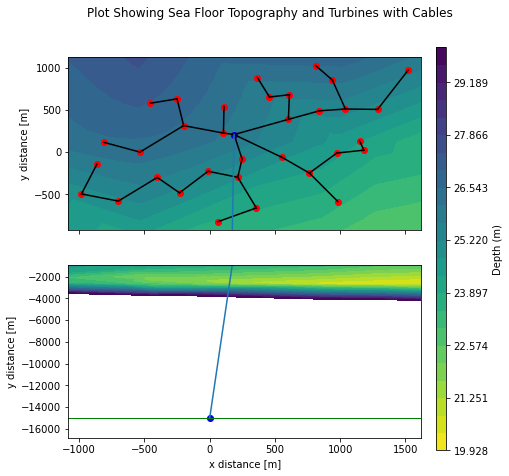

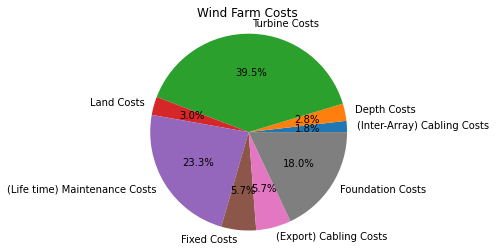

In [431]:
## GUASSIAN LAYOUT AND GAUSSIAN TESTING
## INPUTS (DO NOT OVERWRITE): smallestpositionlist, smallestindiceslist, OptimizedTPO, smallestTotalCost
## Calculates results for the optimised positionlist
distance,angle,distance_global,angle_global = geom_analysis(smallestpositionlist,smallestindiceslist)
MSTweight = Minimum_Spanning_Tree(distance,smallestindiceslist)
wsr=windspeedreduction(positionlist[1:,:],angles,predict_class)
powout=power(wsr,velocities) # total output power
output=np.tensordot(powout,wsp,axes=2)
print(f'positionlist[1:,:].shape = {positionlist[1:,:].shape}\n angles.shape = {angles.shape}')
## Below calculates max theoreticl power output
wsr_noWake = np.multiply(0.92477772, np.ones(wsr.shape))  ## 0.92477772 is not 1 because of the impact of the hub height
powout_noWake = power(wsr_noWake,velocities)
output_noWake=np.tensordot(powout_noWake,wsp,axes=2)
theoretical_max_power = np.sum(output_noWake)

## Displays imported optimised layout
print('\033[1m'+'\033[4m'+'POST-OPTIMISED LAYOUT INFORMATION (GAUSSIAN LAYOUT & TESTING)'+'\033[0m'+'\033[0m')
print()
OptimizedTPO = smallestTotalCost/smallestCostPerWatt
plotting_function(smallestpositionlist,smallestindiceslist,MSTweight,data,OnshoreSubstation,smallestExportDistance)
OptimizedPayBackTime,OptimizedDiscountedPayBackTime,OptimizedNPV,OptimizedProfIndex = Payback(OptimizedTPO,smallestTotalCost,smallestpositionlist)
print('\033[1m'+'Total Power Output:'+'\033[0m', OptimizedTPO, 'W')
print('\033[1m'+'Theoretical Max Total Power Output:'+'\033[0m', theoretical_max_power, 'W')
print('\033[1m'+'Percentage power lost to wake effcts:'+'\033[0m', (1-(OptimizedTPO/theoretical_max_power))*100, '%')
print('\033[1m'+'Cost per Watt'+'\033[0m',smallestCostPerWatt,'£/W')
print('')
print('\033[1m'+'Payback Time:'+'\033[0m',OptimizedPayBackTime,'years')
print('\033[1m'+'Discounted Payback Time:'+'\033[0m',OptimizedDiscountedPayBackTime,'years')
print('\033[1m'+'NPV: £'+'\033[0m',OptimizedNPV,'over a ',LifeTimeTurbineOperatingTime,'year period')
print('\033[1m'+'Profitability Index: £'+'\033[0m',OptimizedProfIndex,'over a ',LifeTimeTurbineOperatingTime,'year period')

In [432]:
## SAVE VARIABLE TO FILE FOR USE IN OTHER CODE
import pickle

optimised_farm_variables = {'smallestpositionlist': smallestpositionlist, 'smallestindiceslist': smallestindiceslist, 'OptimizedTPO': OptimizedTPO, 'smallestTotalCost': smallestTotalCost, 'smallestCostPerWatt': smallestCostPerWatt, 'smallestExportDistance': smallestExportDistance, 'MSTWeightSum':MSTWeightSum}
with open('optimised_farm_variables.pkl', 'wb') as f:
    pickle.dump(optimised_farm_variables, f)

In [433]:
# ## IMPORTED LAYOUT AND GAUSSIAN TESTING
# ## note: only valid for the same parameters as the code that generated this layout
# ## IMPORT ATTENUATION LAYOUT
# dang = 10;
# windangle = 10;
# import pickle
# with open('optimised_farm_variables.pkl', 'rb') as f:
#     my_variables = pickle.load(f)
# PositionList_imported = my_variables['smallestpositionlist'] ## valid import
# IndicesList_imported = my_variables['smallestindiceslist'] ## valid import
# ExportDistance_imported = my_variables['smallestExportDistance'] ## valid import
# MSTWeightSum_imported = my_variables['MSTWeightSum'] ## valid import (total length of cabling)(this import breaks the idea of a position only import, but I don't understand the MST rn)

# ## Calculates various financial data relating to the position list imported
# OnshoreSubstation,ExportDistance_exp = Substation_To_Shore_Connection(PositionList_imported)
# FoundationCostTotal_exp = foundations(PositionList_imported)
# ExportCableCost_exp = (ExportDistance_imported*ExportCableCostperMeter) # Export cable cost
# FixedCost_exp = (OffshoreSubstationCostperMW+OnshoreSubstationCostperMW)*TurbineRating*nturb
# CableCost_exp = (MSTWeightSum_imported/1000)*IACableCostperMeter
# DepthCostAll_exp = depthvalues(PositionList_imported)[0]
# TurbineCostTotal_exp = (nturb)*CostperTurbine
# MaintenanceCosts_exp = (nturb)*MaintenanceCostperTurbine
# LandCost_exp = LandAreaCost(PositionList_imported,ExportDistance_imported)
# TotalCost_exp = TurbineCostTotal_exp+DepthCostAll_exp+MaintenanceCosts_exp+FixedCost_exp+LandCost_exp+CableCost_exp+ExportCableCost_exp+FoundationCostTotal_exp

# ## Calculates results for the imported optimised positionlist
# distance_exp,angle,distance_global,angle_global = geom_analysis(PositionList_imported,IndicesList_imported)
# MSTweight = Minimum_Spanning_Tree(distance_exp,IndicesList_imported)
# wsr_exp = windspeedreduction(PositionList_imported[1:,:],angles,predict_class)
# powout_exp = power(wsr_exp,velocities) # total output power
# output_exp = np.tensordot(powout_exp,wsp,axes=2)
# TotalPower_exp = np.sum(output_exp)
# CostPerWatt_exp = TotalCost_exp/TotalPower_exp

# ## Below calculates max theoretical power output
# wsr_noWake = np.multiply(0.92477772, np.ones(wsr_exp.shape))  ## 0.92477772 is not 1 because of the impact of the hub height
# powout_noWake = power(wsr_noWake,velocities)
# output_noWake=np.tensordot(powout_noWake,wsp,axes=2)
# TotalPower_noWake = np.sum(output_noWake)

# ## Displays imported optimised layout
# print('\033[1m'+'\033[4m'+'POST-OPTIMISED LAYOUT INFORMATION (IMPORTED LAYOUT W/ GAUSSIAN TESTING)'+'\033[0m'+'\033[0m')
# print()
# plotting_function(PositionList_imported,IndicesList_imported,MSTweight,data,OnshoreSubstation,ExportDistance_imported)
# OptimizedPayBackTime,OptimizedDiscountedPayBackTime,OptimizedNPV,OptimizedProfIndex = Payback(TotalPower_exp,TotalCost_exp,PositionList_imported)
# print('\033[1m'+'Total Power Output:'+'\033[0m', TotalPower_exp, 'W')
# print('\033[1m'+'Theoretical Max Total Power Output:'+'\033[0m', TotalPower_noWake, 'W')
# print('\033[1m'+'Percentage power lost to wake effcts:'+'\033[0m', (1-(TotalPower_exp/TotalPower_noWake))*100, '%')
# print('\033[1m'+'Cost per Watt'+'\033[0m',CostPerWatt_exp,'£/W')
# print('')
# print('\033[1m'+'Payback Time:'+'\033[0m',OptimizedPayBackTime,'years')
# print('\033[1m'+'Discounted Payback Time:'+'\033[0m',OptimizedDiscountedPayBackTime,'years')
# print('\033[1m'+'NPV: £'+'\033[0m',OptimizedNPV,'over a ',LifeTimeTurbineOperatingTime,'year period')
# print('\033[1m'+'Profitability Index: £'+'\033[0m',OptimizedProfIndex,'over a ',LifeTimeTurbineOperatingTime,'year period')

In [434]:
# 8 turbines produce 6MW of output, which is 37.5% of their max output, which is roughly correct.
# If the wind speed decreases by half, power production decreases by a factor of eight.
# On average, therefore, wind turbines do not generate near their capacity.
# Industry estimates project an annual output of 30-40%, but real-world experience shows that
# annual outputs of 15-30% of capacity are more typical in a year. Therefore this improved 37.5% is good.

In [435]:
print(res.success) # whether the minization was succesful or not
print(res.status) # termination status
print(res.message) # Description of the cause of termination
print(res.nit) # number of iterations performed by the optimizer

True
0
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
11
